# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from matplotlib import pyplot as plt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import xgboost as xgb
from sklearn import ensemble as en
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Loading Data
data = pd.read_csv( 'work/train.csv')

## 0.1 Helper Function

In [3]:
def notebook_settings():
    '''Define configurations for notebook, matplotlib and Pandas.'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    
    sns.set()

In [4]:
notebook_settings()

# 1 Descrição dos dados

In [5]:
df1 = data.copy()

In [6]:
df1.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.172,2577.050,24196.896,104.307,31.039,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.874,2465.390,19227.378,69.859,36.917,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.643,1055.290,42822.282,134.201,34.562,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.141,703.050,51786.826,297.350,31.494,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.716,891.290,44626.853,134.201,28.029,2,8,7,24,10,8,20,Sim,Não,Negar


- balanceamento 
- cross validation 
- substituir outliers por um intervalo do desvio padrão
- Fazer redução de dimensionalidade/arrumar features por árvore

## 1.1 Data Dimensions

In [7]:
df1.shape

(9500, 17)

## 1.2. Data Types

In [8]:
df1.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.3. Check NA

In [9]:
df1.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## 1.4 Descriptive Statistics

In [10]:
num_attributes = df1.select_dtypes( include={ 'int64', 'float64' } )
cat_attributes = df1.select_dtypes( exclude={ 'int64', 'float64' } )

In [11]:
# Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['atributos', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m

,atributos,min,max,range,media,mediana,std,skew,kurtosis
0,id_cliente,1.000,12500.000,12499.000,6210.533,6172.500,3603.054,0.014,-1.199
1,idade,18.000,8598.000,8580.000,126.398,38.000,685.000,9.093,87.613
2,saldo_atual,0.089,1602.041,1601.952,404.532,337.170,217.685,1.622,3.105
3,divida_atual,0.230,4998.070,4997.840,1437.086,1175.730,1156.202,1.188,0.848
4,renda_anual,10473.865,23279657.976,23269184.111,195037.274,45991.106,1454197.190,11.874,149.389
5,valor_em_investimentos,0.000,10000.000,10000.000,611.999,134.201,2002.338,4.436,17.868
6,taxa_utilizacao_credito,20.993,49.565,28.572,32.271,32.263,5.106,0.042,-0.916
7,num_emprestimos,0.000,1496.000,1496.000,10.864,3.000,62.552,16.366,310.980
8,num_contas_bancarias,0.000,1779.000,1779.000,17.552,6.000,120.974,10.878,123.218
9,num_cartoes_credito,1.000,1479.000,1478.000,21.433,6.000,122.671,8.564,76.795


Outliers:

- Idade
- Renda anual (23mi ?)
- Número de empréstimos
- Número de contas bancarias
- Número de cartões de crédito
- Número de pagamentos atrasados
- Número de consultas de crédito

# 2 Filtragem de variáveis

In [393]:
df2 = df1.copy()

In [13]:
df1.shape

(9500, 17)

In [14]:
df2.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.172,2577.050,24196.896,104.307,31.039,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.874,2465.390,19227.378,69.859,36.917,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.643,1055.290,42822.282,134.201,34.562,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.141,703.050,51786.826,297.350,31.494,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.716,891.290,44626.853,134.201,28.029,2,8,7,24,10,8,20,Sim,Não,Negar


In [394]:
# Filtragem de linhas - Idade
df2 = df2[df2['idade'] < 102]
#idade_median = df3['idade'].median()
#df3['idade'] = df3['idade'].apply(lambda x: idade_median if x >=102.0 else x)


# Filtragem de linhas - Numero de emprestimos
#df3 = df3[df3['num_emprestimos'] < 93]
#num_empr_median = df3['num_emprestimos'].median()
#df3['num_emprestimos'] = df3['num_emprestimos'].apply(lambda x: num_empr_median if x >=93 else x) #best


# Filtragem de linhas - Numero de contas bancarias
#df3 = df3[df3['num_contas_bancarias'] < 33]
#num_conta_median = df3['num_contas_bancarias'].median()
#df3['num_contas_bancarias'] = df3['num_contas_bancarias'].apply(lambda x: num_conta_median if x >=33 else x) #best


# Filtragem de linhas - Numero de cartoes                #Boa opção
#df3 = df3[df3['num_cartoes_credito'] < 16]
num_cartao_median = df2['num_cartoes_credito'].median()
df2['num_cartoes_credito'] = df2['num_cartoes_credito'].apply(lambda x: num_cartao_median if x >=16 else x) #best



# Filtragem de linhas - Numero de pagamentos atrasados    # Boa opção
#df3 = df3[df3['num_pgtos_atrasados'] < 85]
num_pgto_median = df2['num_pgtos_atrasados'].median()
df2['num_pgtos_atrasados'] = df2['num_pgtos_atrasados'].apply(lambda x: num_pgto_median if x >=85 else x) # Best


# Filtragem de linhas - Numero de consultas de credito
#df3 = df3[df3['num_consultas_credito'] < 60]
num_consul_median = df2['num_consultas_credito'].median()
df2['num_consultas_credito'] = df2['num_consultas_credito'].apply(lambda x: num_consul_median if x >=60 else x) # Best

In [16]:
df2['num_emprestimos'].max()

1496

In [17]:
df2.shape

(9221, 17)

In [18]:
# Idade: Temos 106 linhas de outliers com idades acima de 101 anos (que seria o limite máximo real)

# Numero de emprestimos: Temos 406 linhas de possiveis outliers com numero de emprestimos a partir de 92

# Numero de contas bancarias: Temos 125 linhas de possiveis outliers com numero de contas a partir de 32

# Numero de cartoes: Temos 212 linhas de possiveis outliers com numero de cartoes a partir de 16

# Numero de pagamentos atrasados: Temos 66 linhas de possiveis outliers com pagamentos a partir de 84

# Numero de consultas de credito: Temos 150 linhas de possiveis outliers com numero de consultas a partir de 59

# 3 Feature Engineering

- Bins para idade, renda anual, investimentos, taxa de crédito, dias_atraso_dt_venc, num_pgtos_atrasados, taxa_juros
- Bins/agrupar divida
- métricas para diferentes cartões de crédito
- razão entre dívida atual/saldo atual ou renda_anual(renda mensal)
- razão entre valor_em_investimentos/saldo_atual ou renda_anual(renda mensal)
- fazer renda mensal e depois razão entre saldo atual/renda mensal

In [548]:
df3 = df2.copy()

In [47]:
df3.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.172,2577.050,24196.896,104.307,31.039,6,5,7.000,21,14.000,9.000,15,Não,Não,Negar
1,11920,40,268.874,2465.390,19227.378,69.859,36.917,5,8,5.000,40,23.000,10.000,18,Não,Não,Negar
2,8910,36,446.643,1055.290,42822.282,134.201,34.562,0,3,6.000,26,13.000,3.000,15,Sim,Não,Negar
3,4964,58,321.141,703.050,51786.826,297.350,31.494,0,3,7.000,12,7.000,2.000,1,Sim,Não,Negar
4,10100,35,428.716,891.290,44626.853,134.201,28.029,2,8,7.000,24,10.000,8.000,20,Sim,Não,Negar


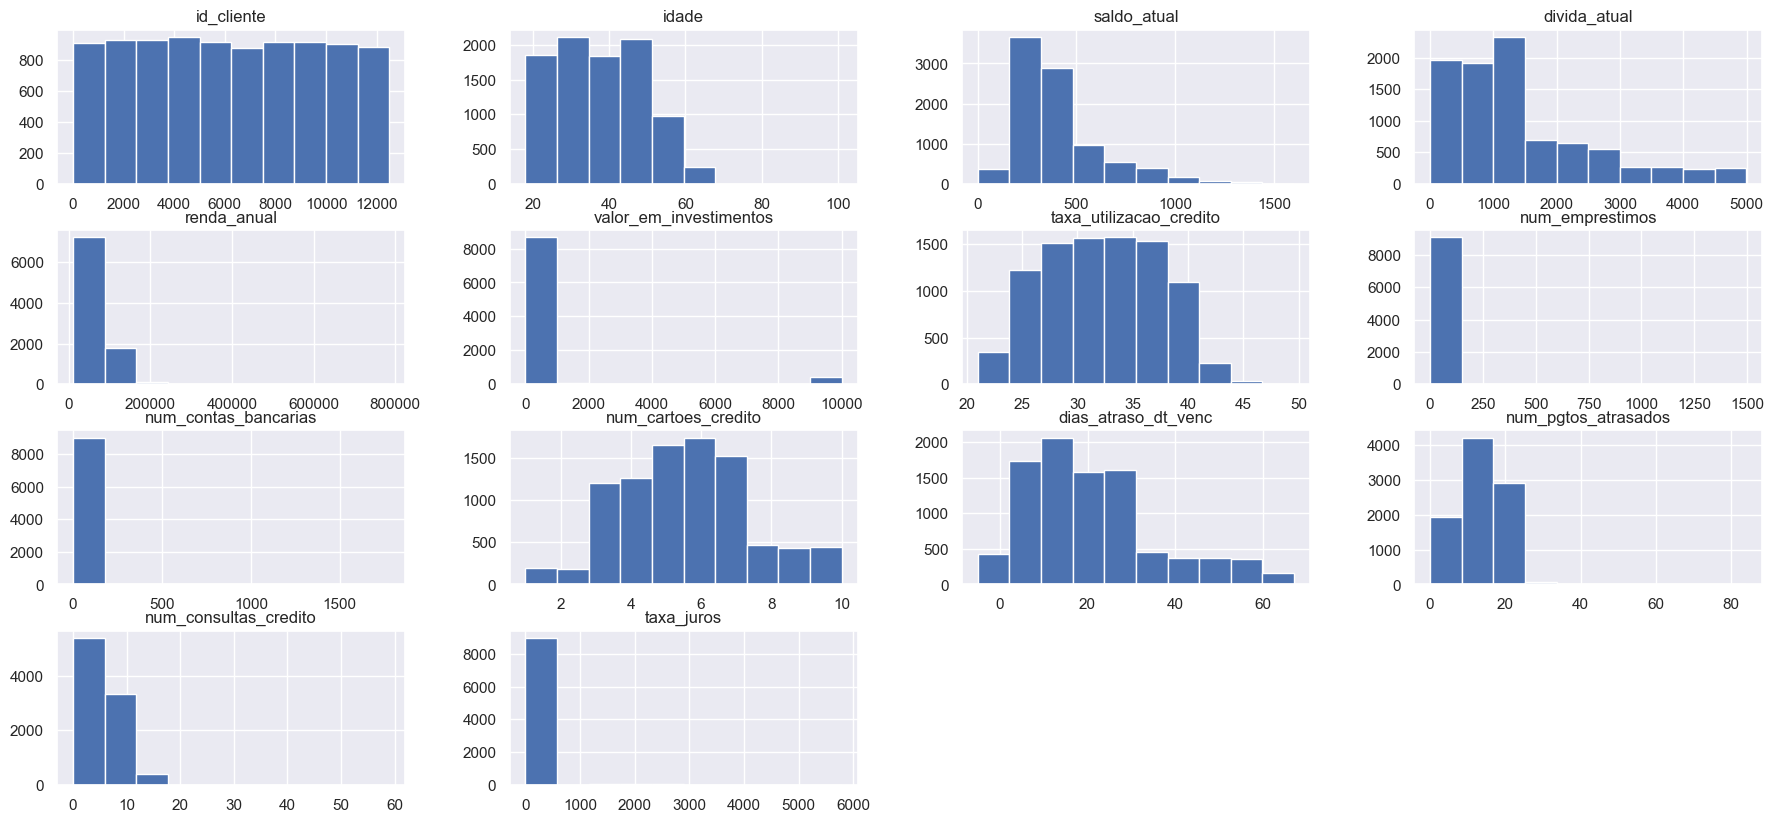

In [76]:
df3[df3['renda_anual'] < 1000000].hist();

In [549]:
# Bins idade
bins = [10, 18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
df3['idade_binned'] = pd.cut(df3['idade'], bins=bins, labels=labels)
df3['idade_binned'] = df3['idade_binned'].astype('int64')

# Bins renda anual - Bom
bins = [10000, 50000, 100000, 200000, 500000, 1000000, 24000000]
labels = [0, 1, 2, 3, 4, 5]
df3['renda_anual_binned'] = pd.cut(df3['renda_anual'], bins=bins, labels=labels)
df3['renda_anual_binned'] = df3['renda_anual_binned'].astype('int64')

# Investimentos
bins = [-0.1, 150, 300, 600, 800, 1000, 1250, 3000, 10000]
labels = [0, 1, 2, 3, 4, 5, 6, 7]
df3['investimentos_binned'] = pd.cut(df3['valor_em_investimentos'], bins=bins, labels=labels)
df3['investimentos_binned'] = df3['investimentos_binned'].astype('int64')

# taxa utilizacao credito
# bins = [10, 22, 26, 29, 31, 37, 40, 43, 45, 50]
# labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# df3['utilizacao_credito_binned'] = pd.cut(df3['taxa_utilizacao_credito'], bins=bins, labels=labels)
# df3['utilizacao_credito_binned'] = df3['utilizacao_credito_binned'].astype('int64')

# dias atraso
bins = [-6, 2, 9, 16, 23, 30, 37, 70]
labels = [0, 1, 2, 3, 4, 5, 6]
df3['atraso_venc_binned'] = pd.cut(df3['dias_atraso_dt_venc'], bins=bins, labels=labels)
df3['atraso_venc_binned'] = df3['atraso_venc_binned'].astype('int64')

# bins = [0, 7, 14, 21, 28, 35, 100, 6000]
# labels = [0, 1, 2, 3, 4, 5, 6]
# df3['taxa_juros_binned'] = pd.cut(df3['taxa_juros'], bins=bins, labels=labels)
# df3['taxa_juros_binned'] = df3['taxa_juros_binned'].astype('int64')

bins = [0, 1000, 2000, 3000, 4000, 5000]
labels = [0, 1, 2, 3, 4]
df3['divida_atual_binned'] = pd.cut(df3['divida_atual'], bins=bins, labels=labels)
df3['divida_atual_binned'] = df3['divida_atual_binned'].astype('int64')

In [550]:
#razão entre dívida atual/saldo atual ou renda_anual(renda mensal)
df3['taxa_divida'] = df3.apply(lambda x: x['divida_atual'] / (x['renda_anual']/12), axis=1)

df3['renda_mensal'] = df3.apply(lambda x: x['renda_anual'] /12, axis=1)


# razão entre valor_em_investimentos/saldo_atual ou renda_anual(renda mensal)
#df3['taxa_aplicacao'] = df3.apply(lambda x: x['valor_em_investimentos'] / (x['renda_anual']/12), axis=1)


# fazer renda mensal e depois razão entre saldo atual/renda mensal
df3['taxa_deposito'] = df3.apply(lambda x: x['saldo_atual'] / x['renda_mensal'], axis=1)

# 4 Análise exploratória dos dados

In [20]:
df4 = df3.copy()

## 4.1. Ánalise Univariada

### Variável Resposta

In [21]:
le_y = pickle.load(open('work/le_y.pkl', 'rb'))
aux = df4.copy()

aux['limite_adicional'] = le_y.transform(aux['limite_adicional'])

In [22]:
# 1 = Negar, 0 = Conceder
aux['limite_adicional'].value_counts(normalize=True)

1   0.842
0   0.158
Name: limite_adicional, dtype: float64

### Idade

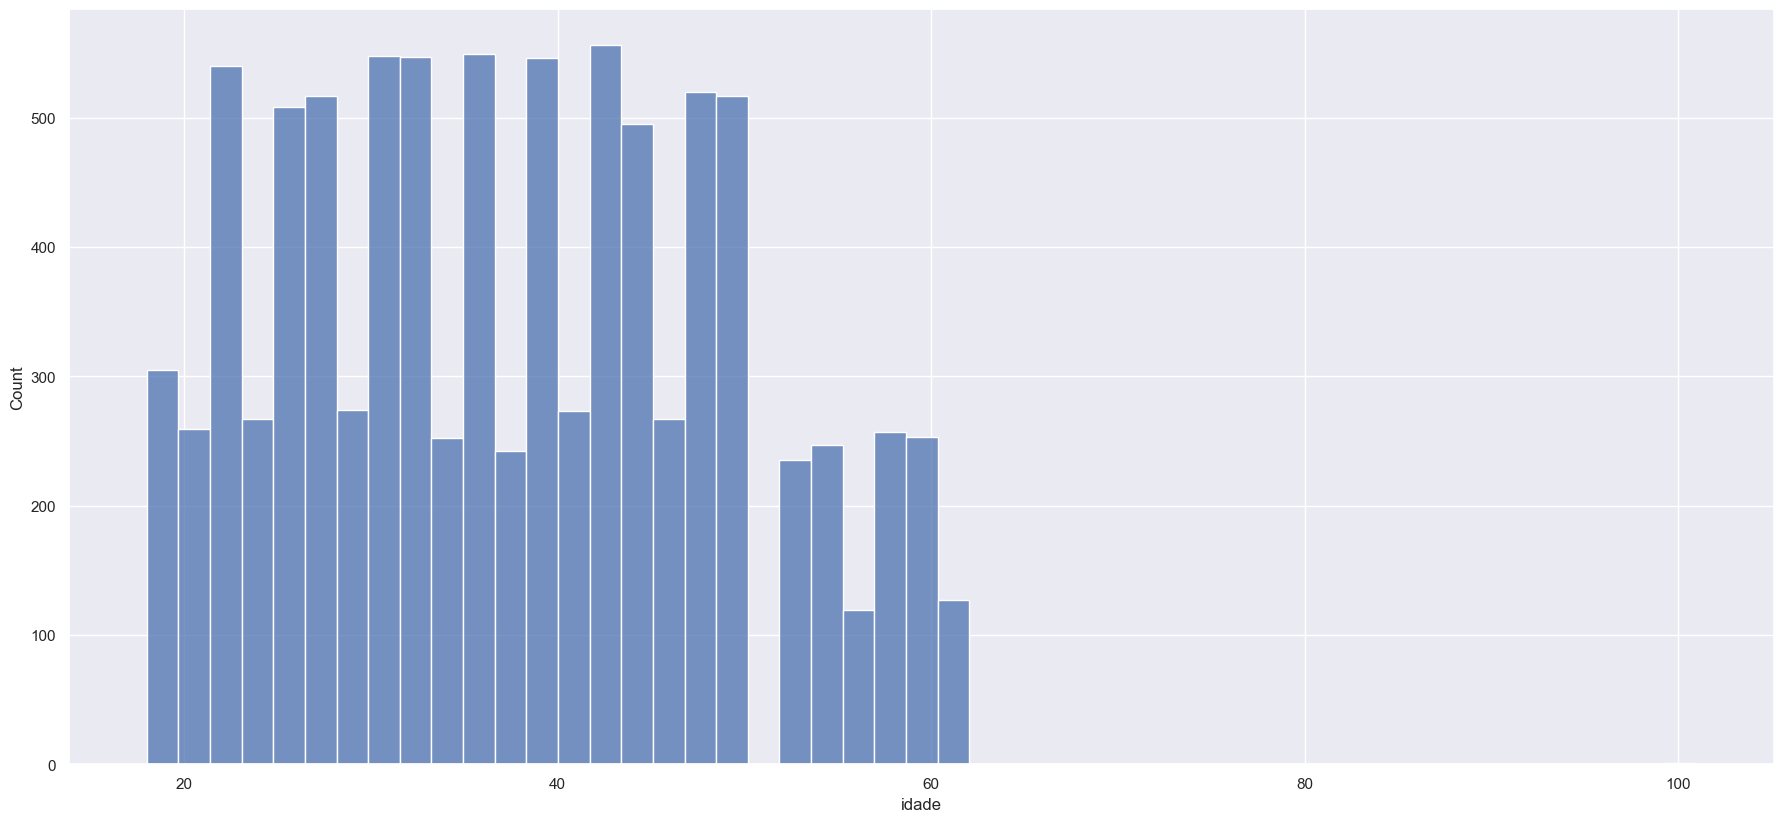

In [23]:
# Dropando outliers
aux1 = df4.loc[ df4['idade'] < 120, : ]

# Plotando gráfico de distribuição
sns.histplot( x='idade', data=aux1 );

### Saldo Atual

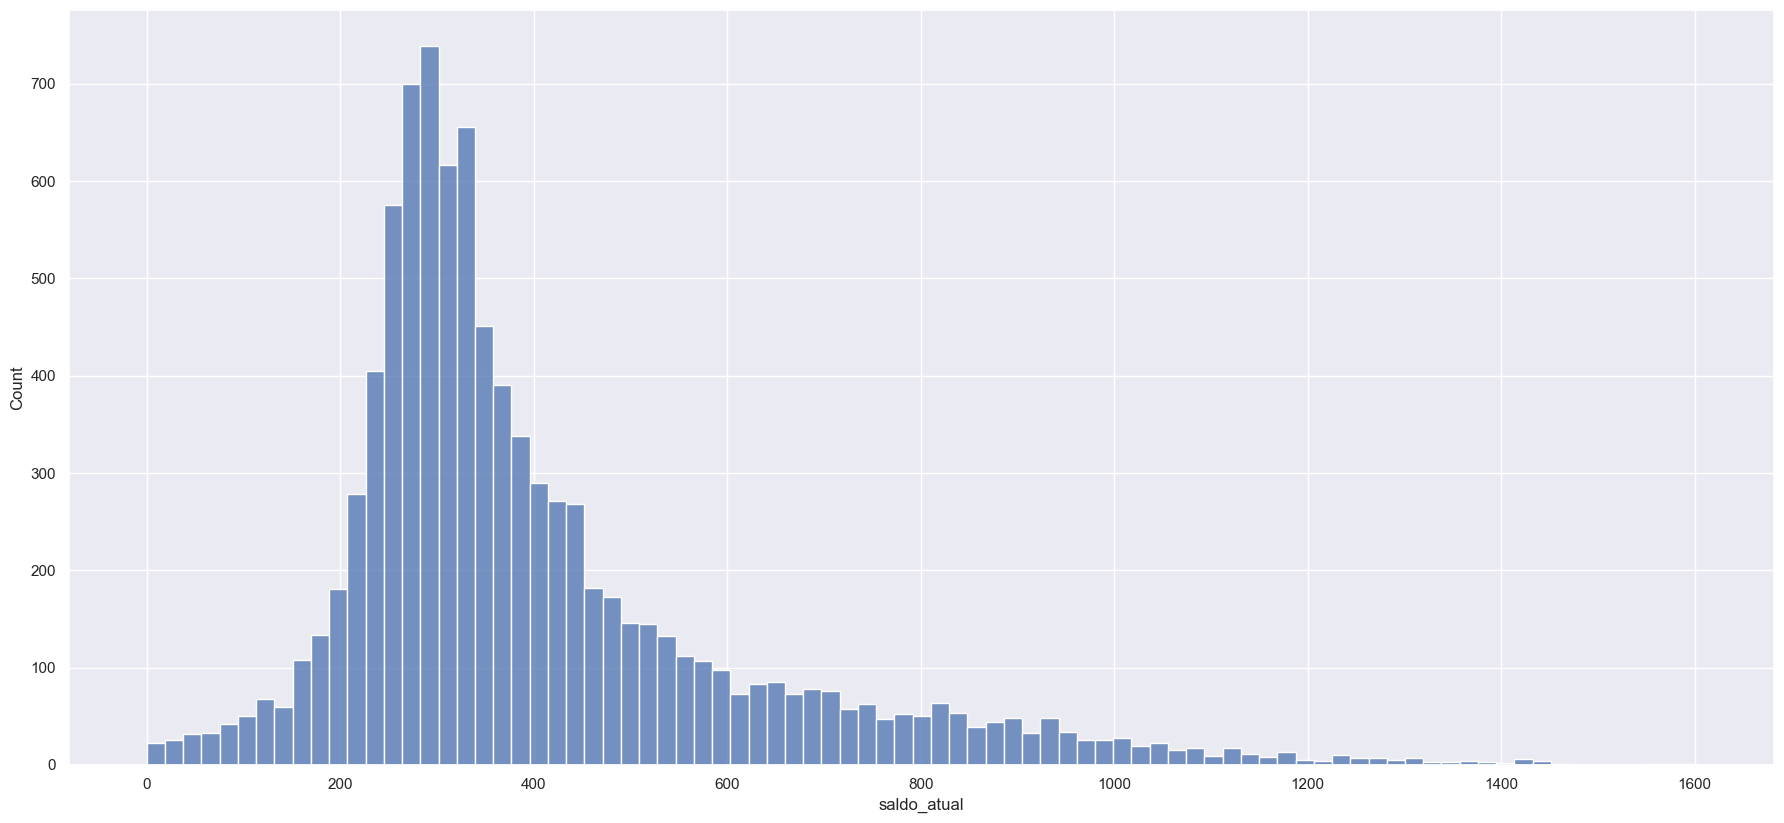

In [24]:
sns.histplot( x='saldo_atual', data=df4 );

### Dívida Atual

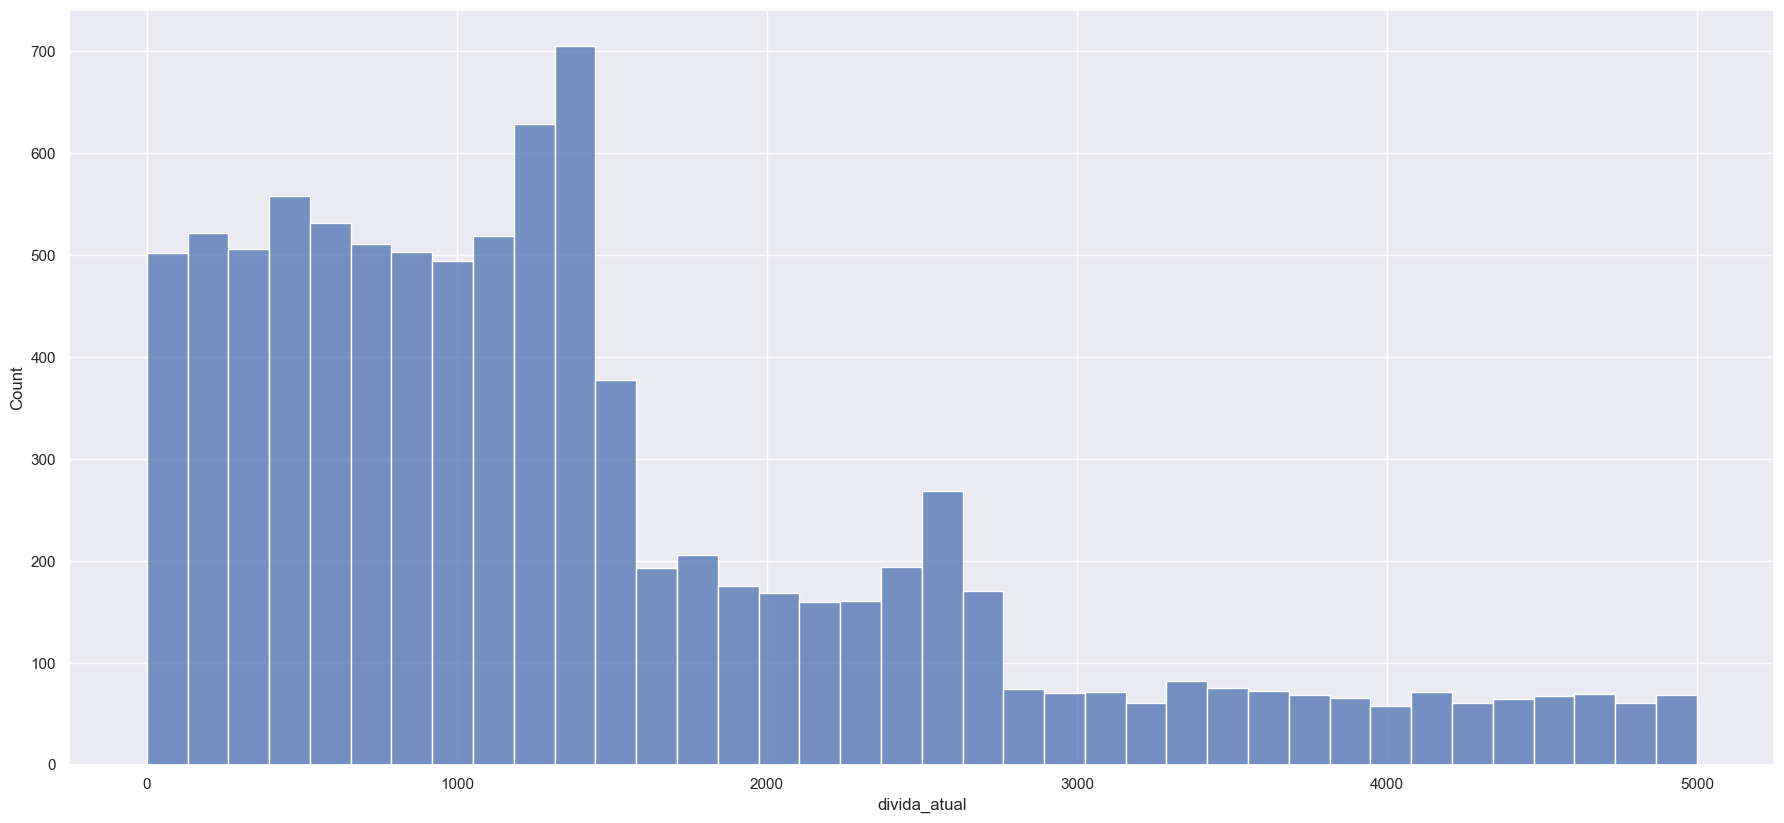

In [25]:
sns.histplot( x='divida_atual', data=df4 );

### Renda Anual

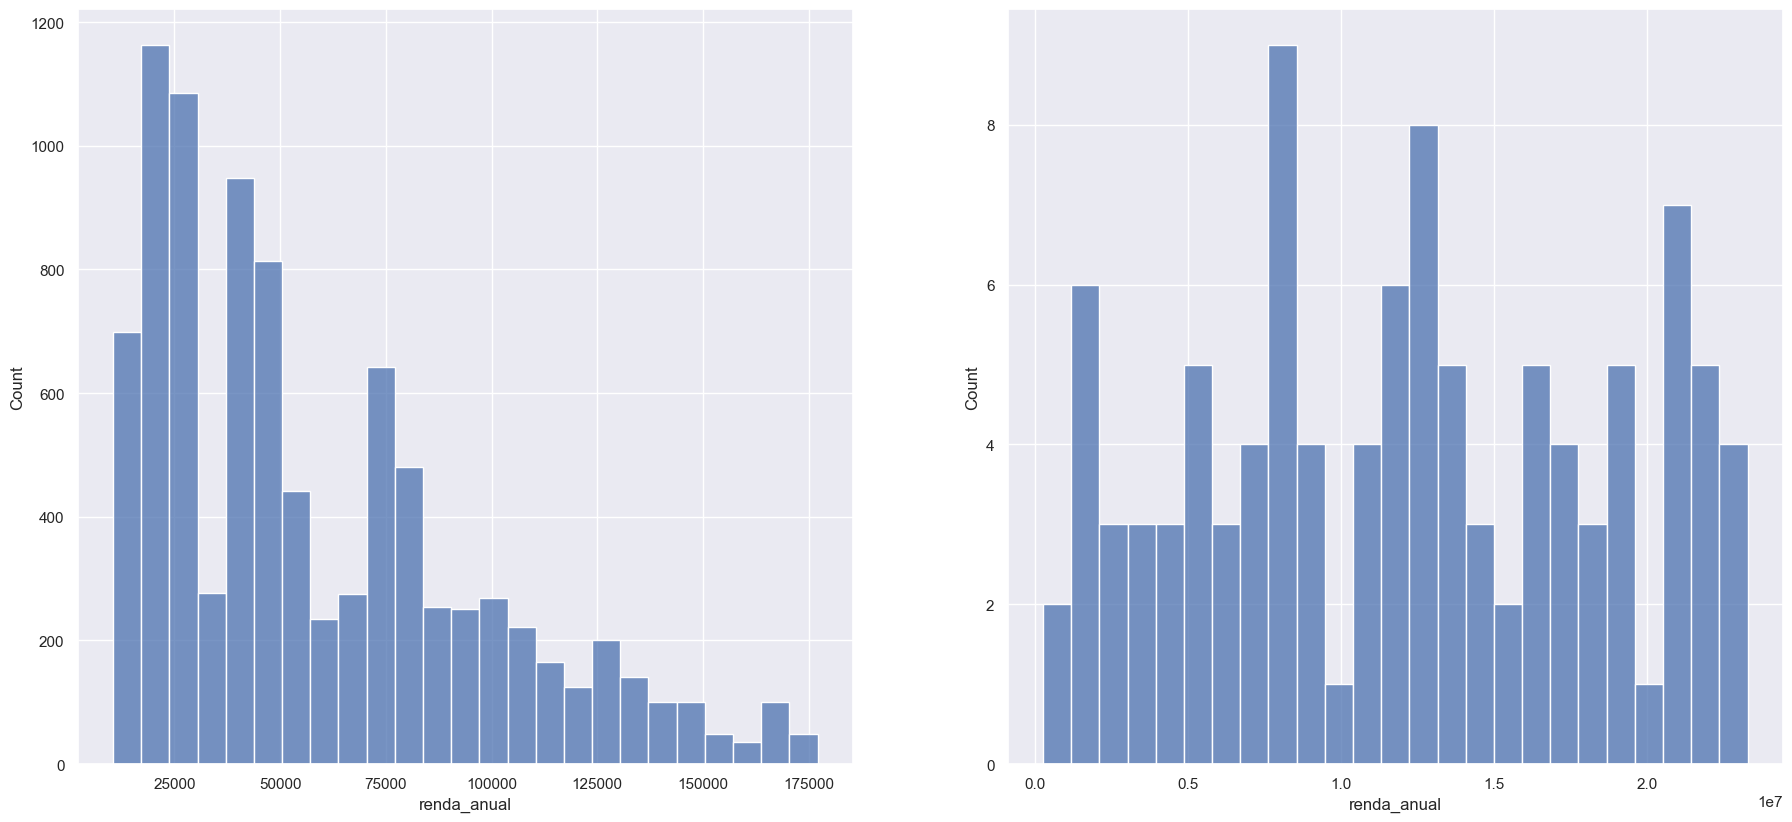

In [26]:
aux1 = df4.loc[ df4['renda_anual'] < 200000, : ]
aux2 = df4.loc[ df4['renda_anual'] > 200000, : ]

plt.subplot( 1, 2, 1 )
sns.histplot( x='renda_anual', data=aux1, bins=25 );

plt.subplot( 1, 2, 2 )
sns.histplot( x='renda_anual', data=aux2, bins=25 );


### Valor em Investimentos

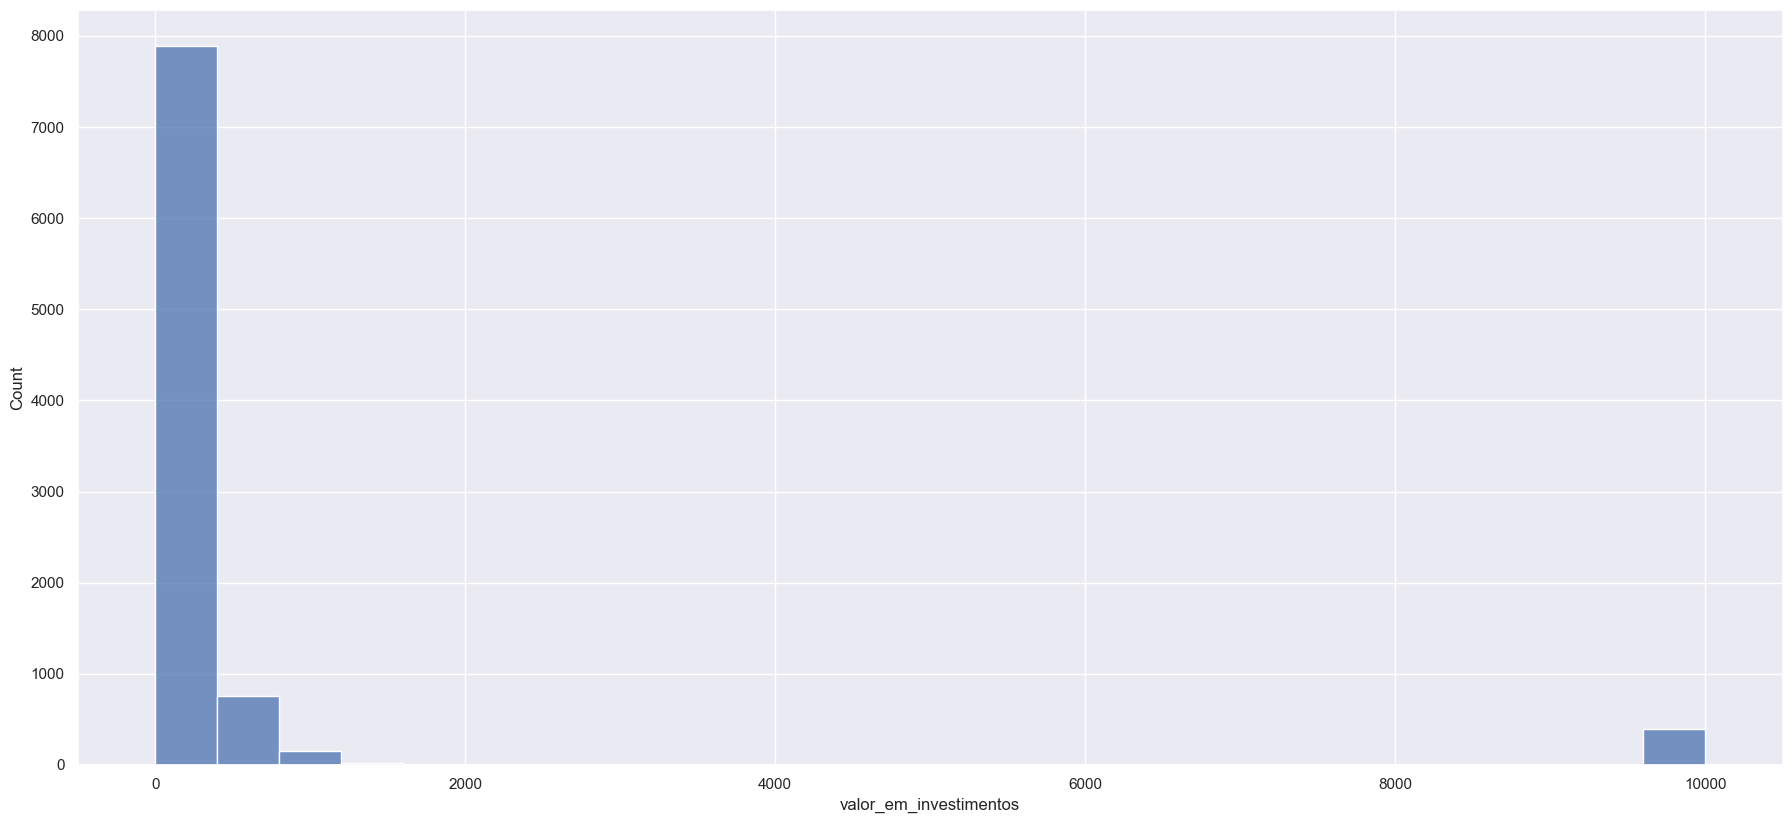

In [27]:
sns.histplot( x='valor_em_investimentos', data=df4, bins=25 );

### Taxa Utilização de Crédito

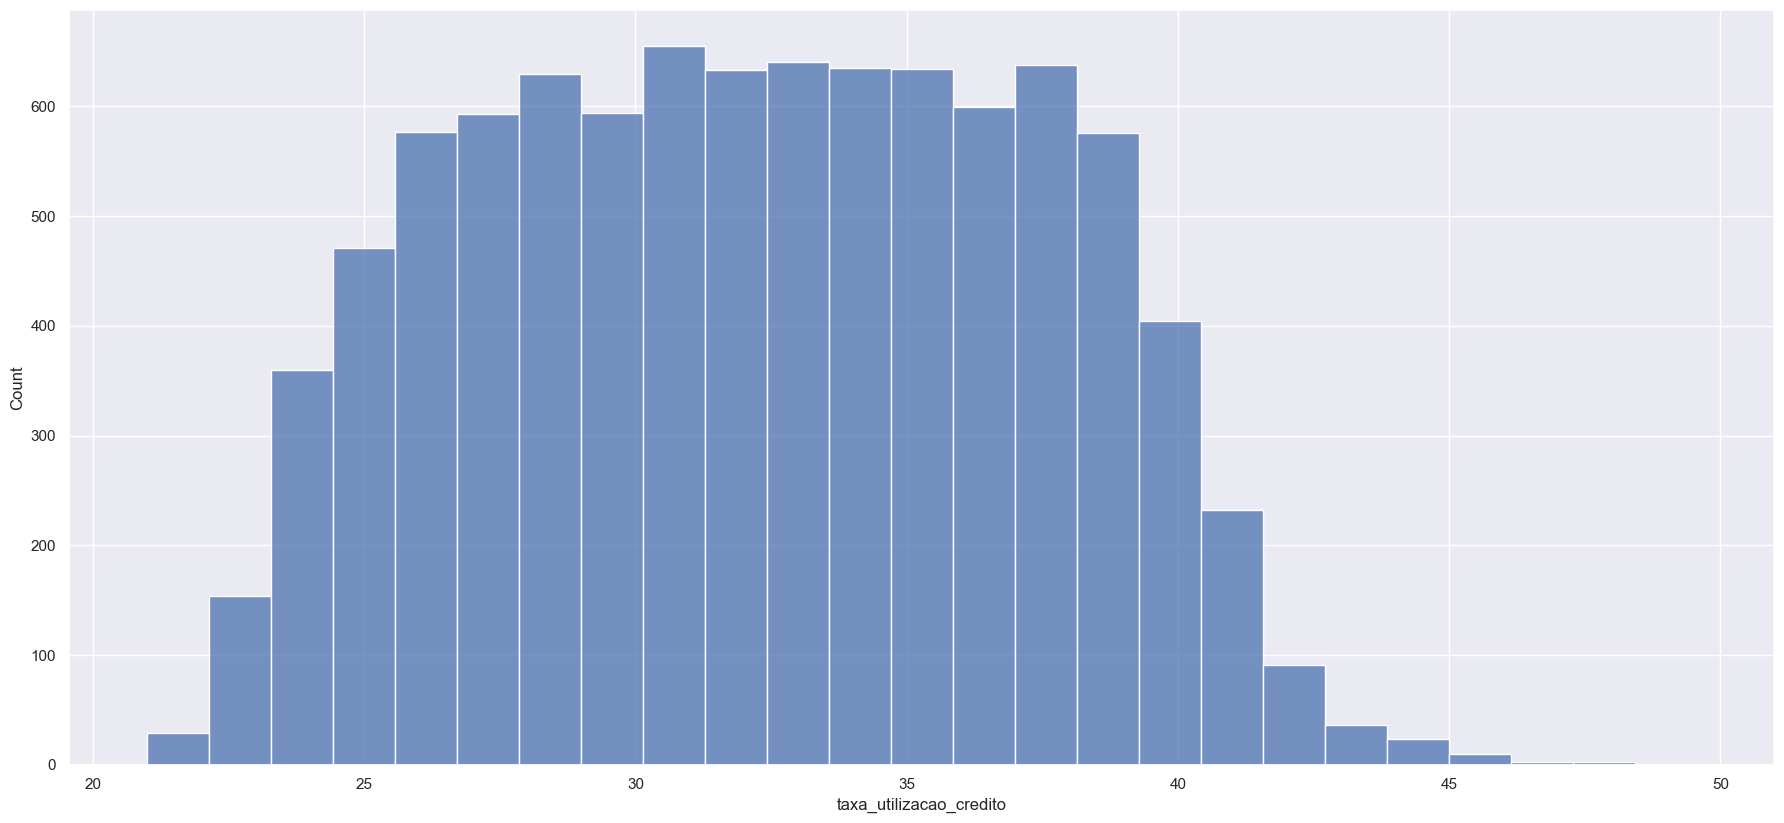

In [28]:
sns.histplot( x='taxa_utilizacao_credito', data=df4, bins=25 );

### Número de empréstimos

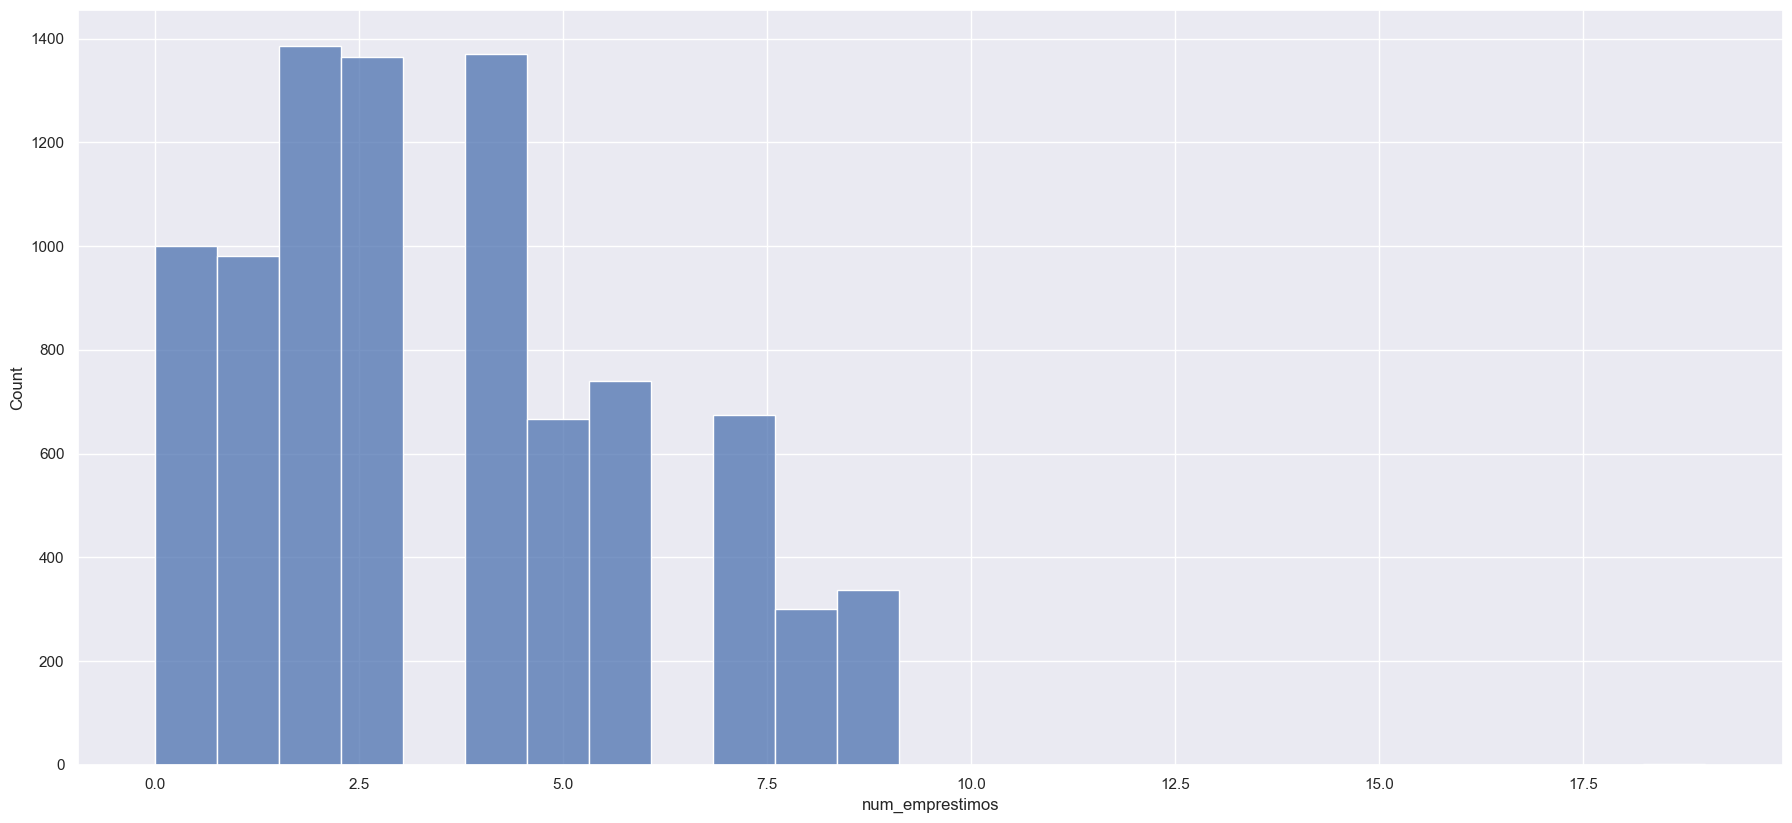

In [29]:
aux1 = df4.loc[ df4['num_emprestimos'] < 50, : ]
sns.histplot( x='num_emprestimos', data=aux1, bins=25 );

### Numero de contas bancarias 

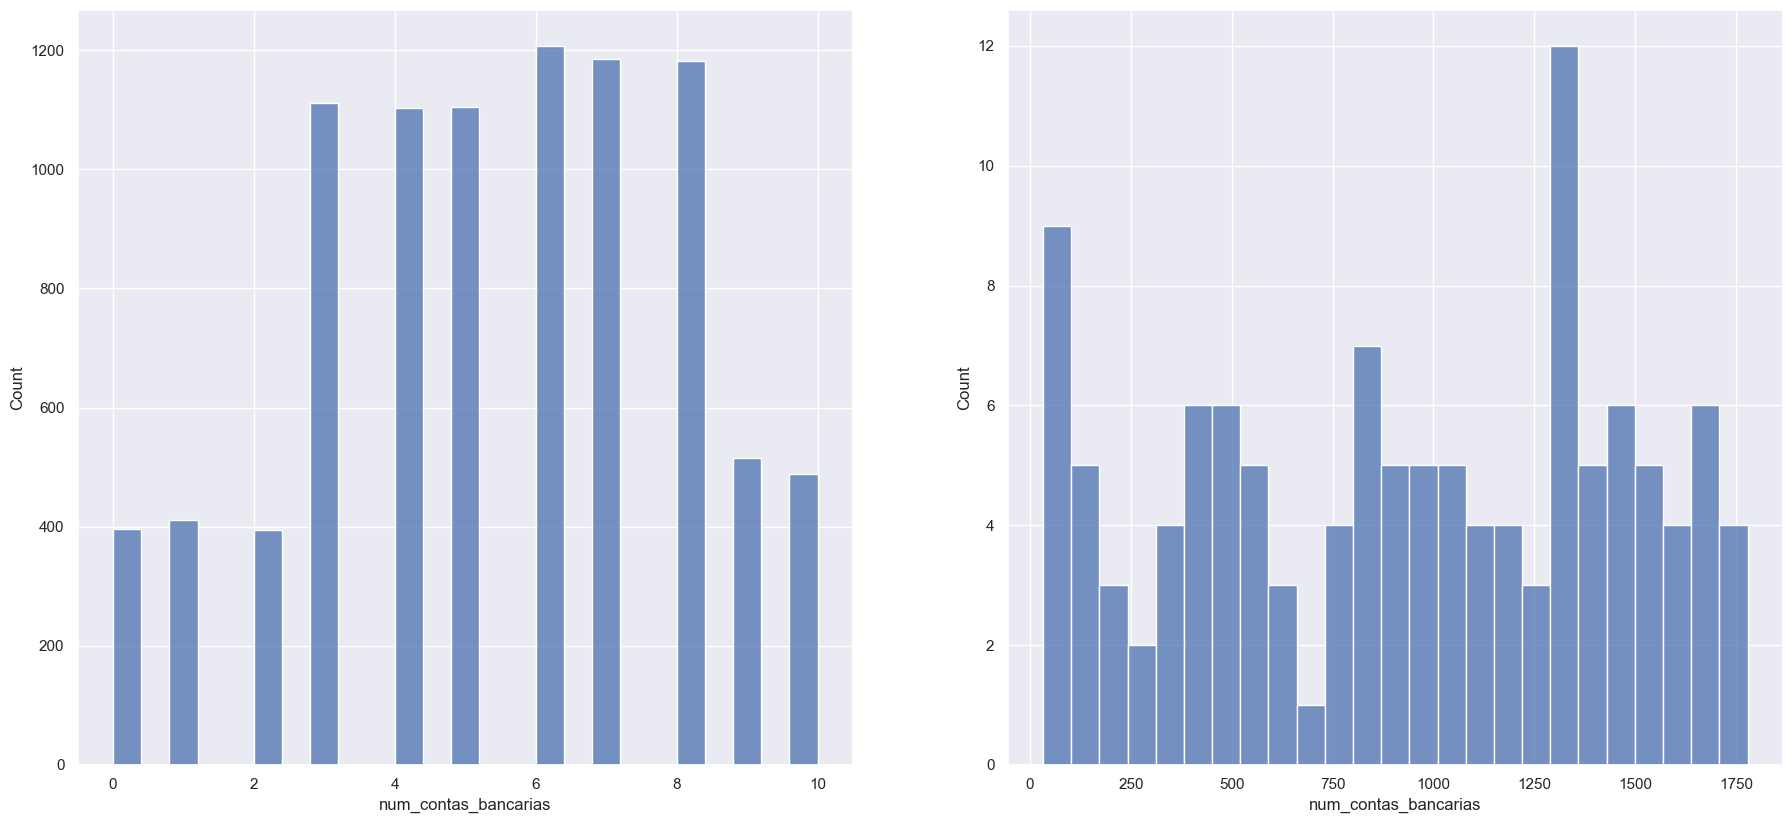

In [30]:
aux1 = df4.loc[ df4['num_contas_bancarias'] < 30, : ]
aux2 = df4.loc[ df4['num_contas_bancarias'] > 30, : ]

plt.subplot( 1, 2, 1 )
sns.histplot( x='num_contas_bancarias', data=aux1, bins=25 );

plt.subplot( 1, 2, 2 )
sns.histplot( x='num_contas_bancarias', data=aux2, bins=25 );

### Numero de cartões de crédito

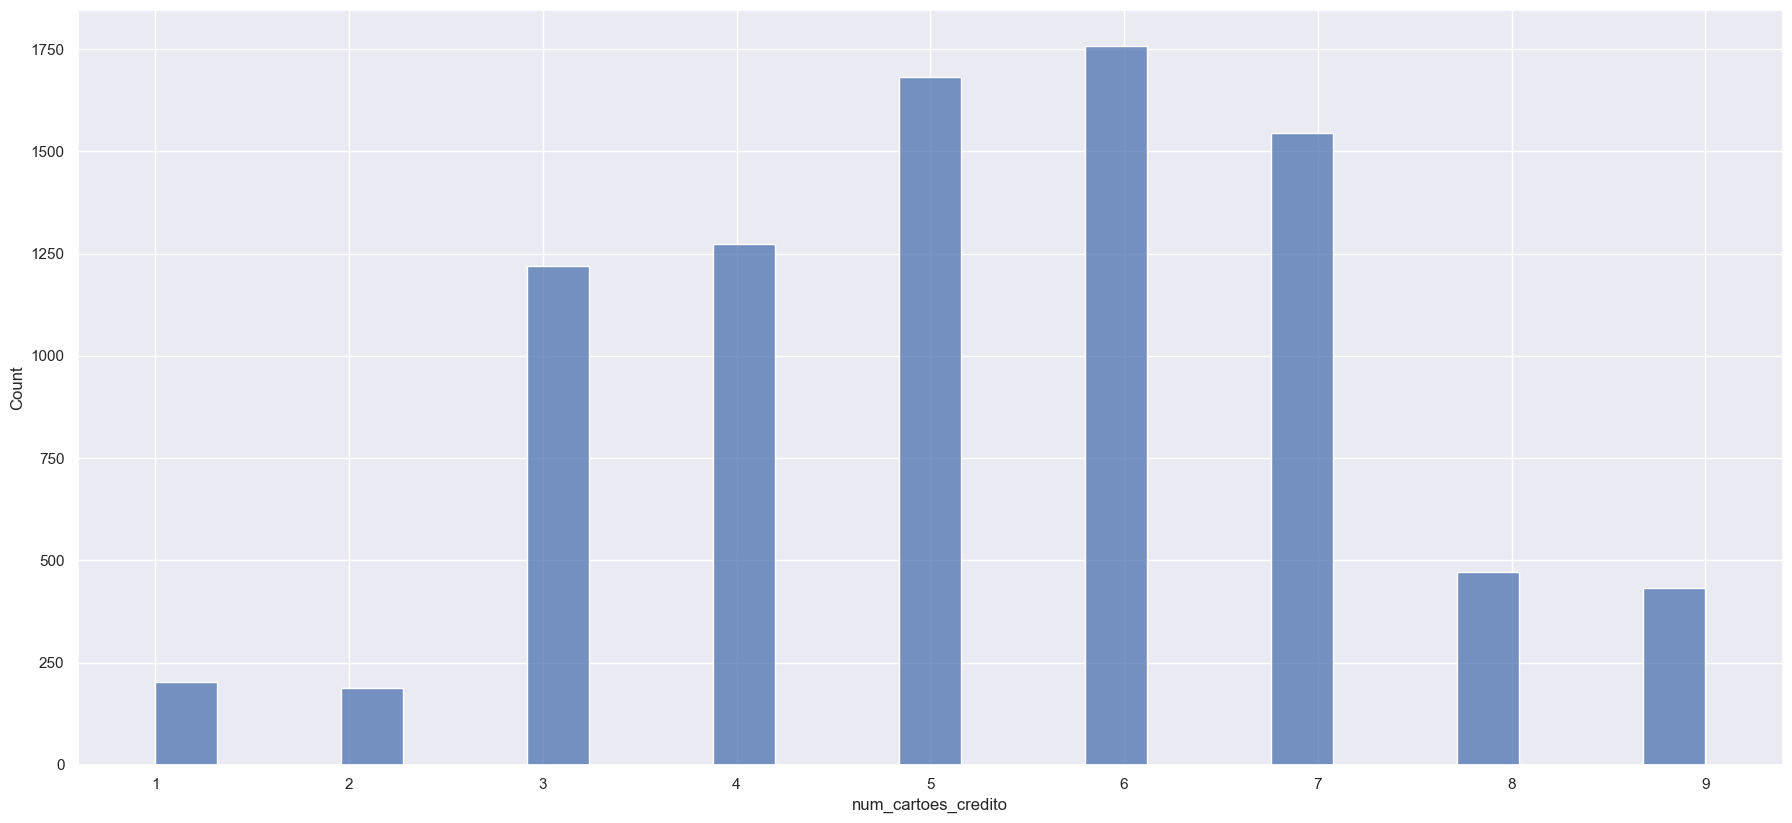

In [31]:
aux1 = df4.loc[ df4['num_cartoes_credito'] < 10, : ]
aux2 = df4.loc[ df4['num_cartoes_credito'] > 10, : ]

sns.histplot( x='num_cartoes_credito', data=aux1, bins=25 );

### Dias Atraso da Data de Vencimento

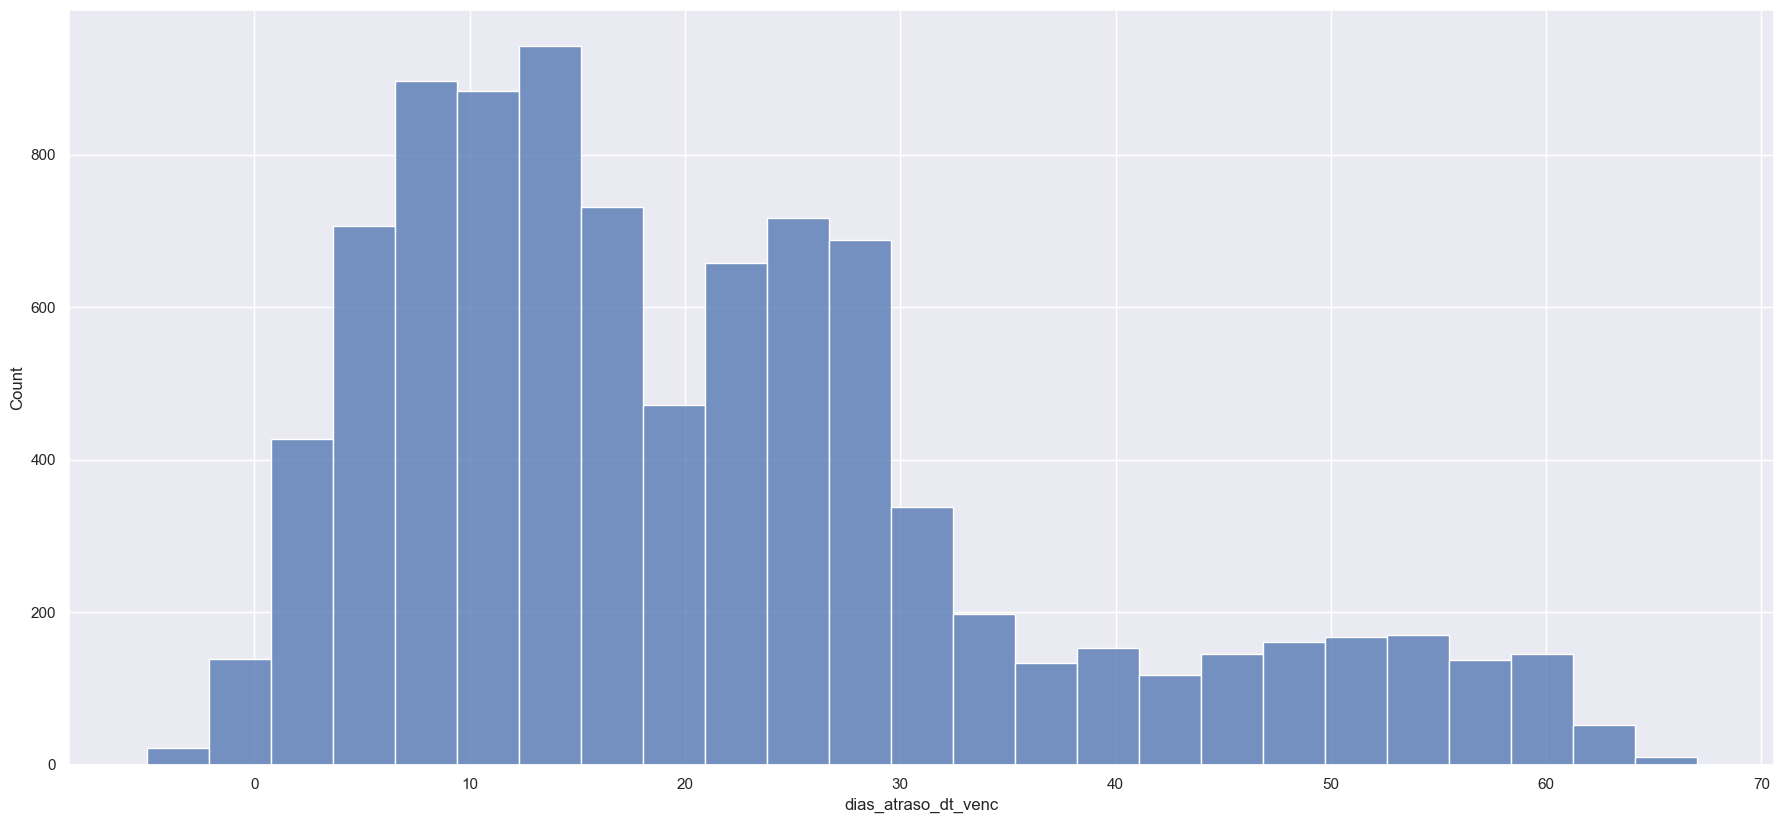

In [32]:
sns.histplot( x='dias_atraso_dt_venc', data=df4, bins=25 );

### Numero de pagamentos atrasados

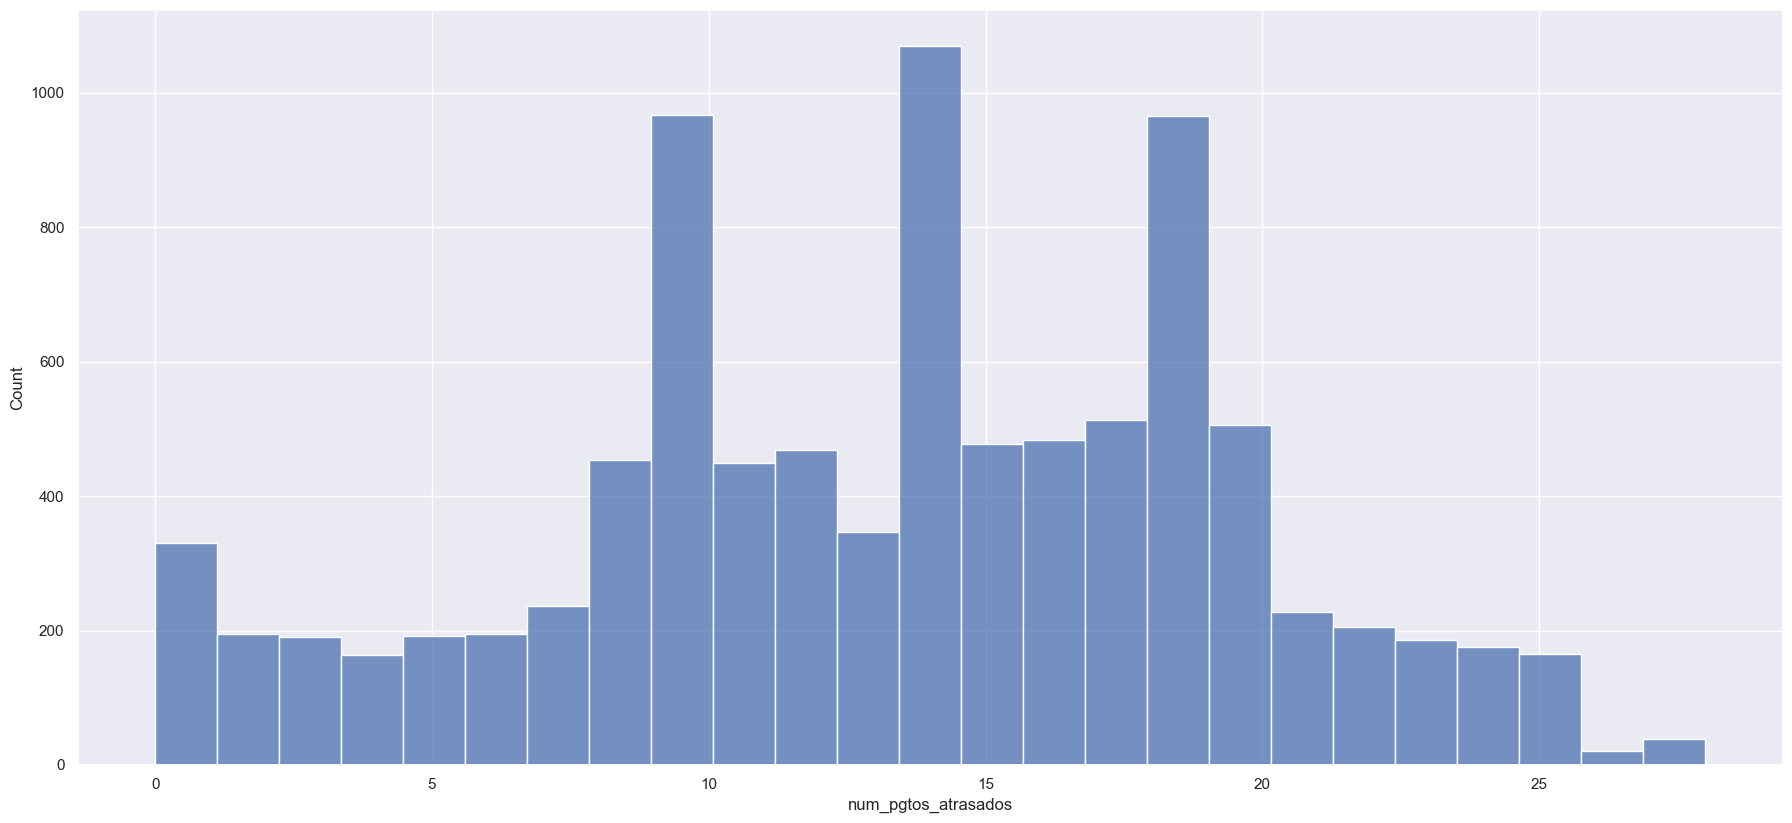

In [33]:
aux1 = df4.loc[ df4['num_pgtos_atrasados'] < 30, : ]
aux2 = df4.loc[ df4['num_pgtos_atrasados'] > 30, : ]

sns.histplot( x='num_pgtos_atrasados', data=aux1, bins=25 );


### Numero de consultas de crédito

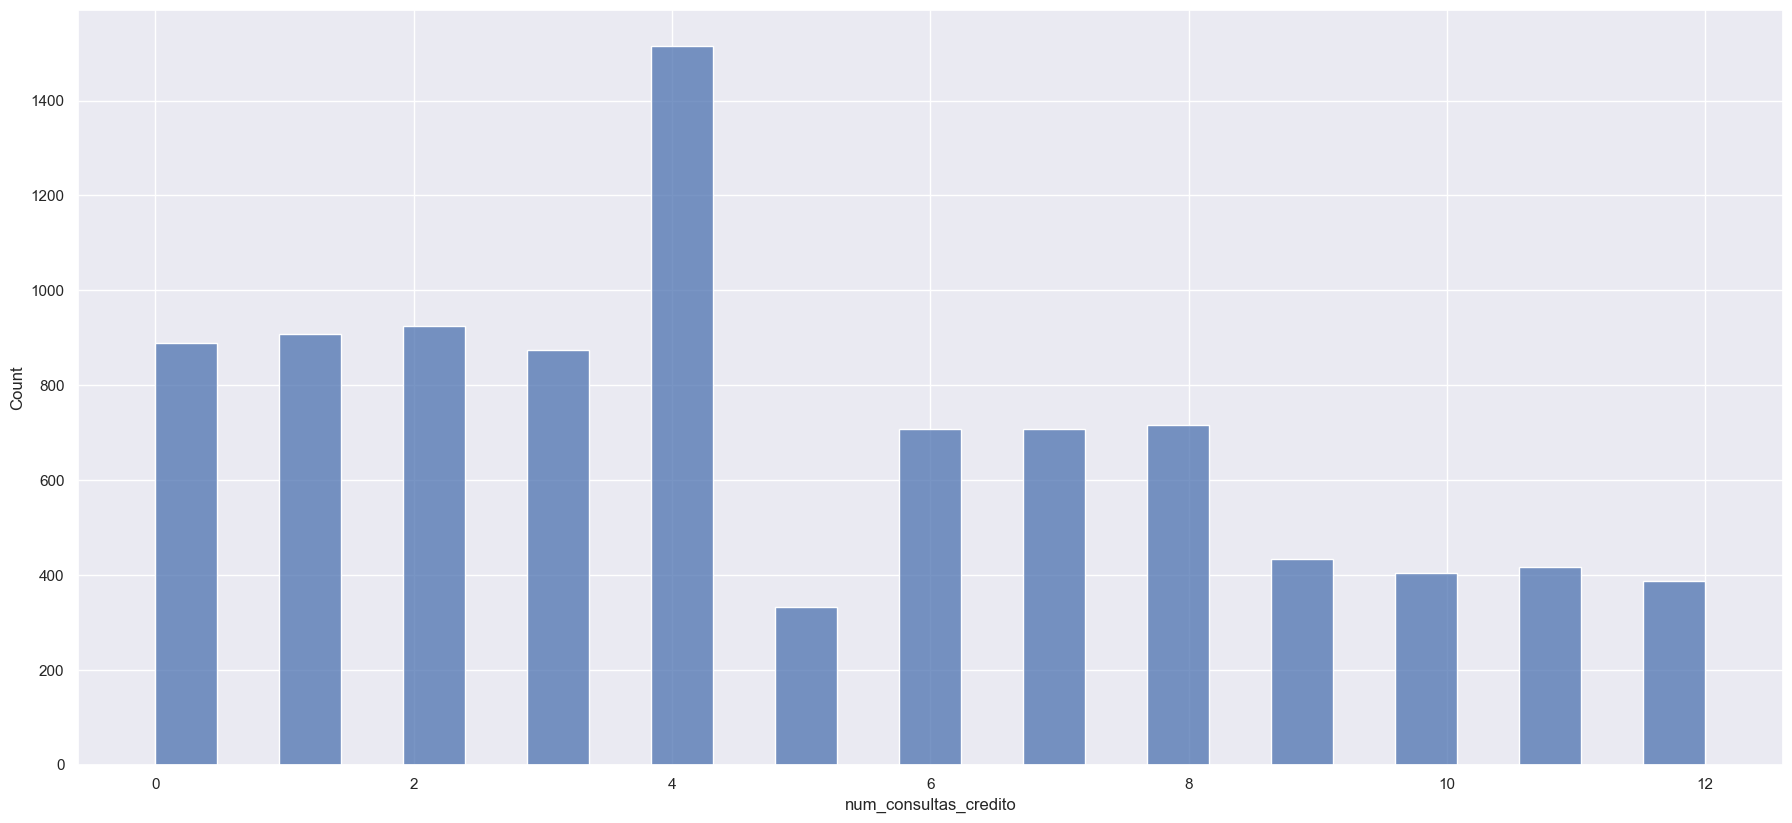

In [34]:
aux1 = df4.loc[ df4['num_consultas_credito'] < 30, : ]
aux2 = df4.loc[ df4['num_consultas_credito'] > 30, : ]
sns.histplot( x='num_consultas_credito', data=aux1, bins=25 );

### Taxa de Juros

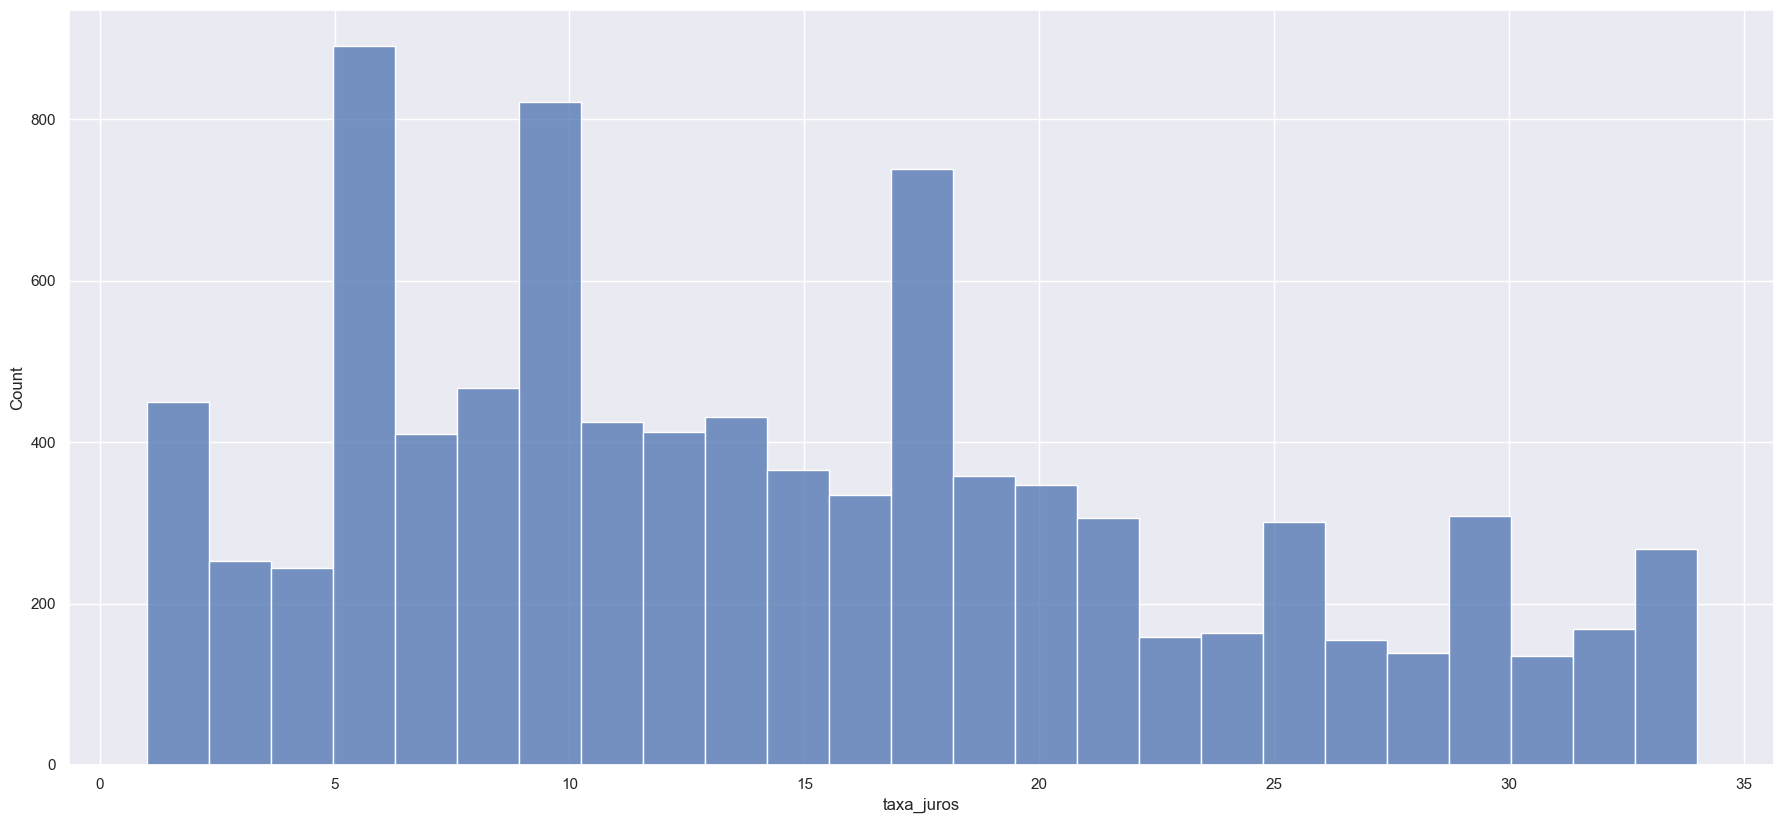

In [35]:
aux1 = df4.loc[ df4['taxa_juros'] < 50, : ]
aux2 = df4.loc[ df4['taxa_juros'] > 50, : ]

sns.histplot( x='taxa_juros', data=aux1, bins=25 );

In [36]:
df4.columns

Index(['id_cliente', 'idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp', 'limite_adicional'],
      dtype='object')

## 4.2 Ánalise Bivariada

### Idade

In [37]:
# Agrupando as idades blocos
df4['idade_agrupada'] = df4['idade'].apply( lambda x: 1 if x < 26 else
                                                               2 if ( 26 >= x < 34 ) else
                                                               3 if ( 34 >= x < 42 ) else
                                                               4 if ( 42 >= x < 50 ) else
                                                               5 if ( 50 >= x < 58 ) else
                                                               6 if ( 58 >= x < 64 ) else
                                                               7)


# Plotando o número de negações por grupo
aux1 = df4[['idade_agrupada', 'limite_adicional']].groupby( 'idade_agrupada' ).sum().reset_index()
#sns.barplot(x='idade_agrupada', y='limite_adicional', data=aux1);

### Saldo Atual

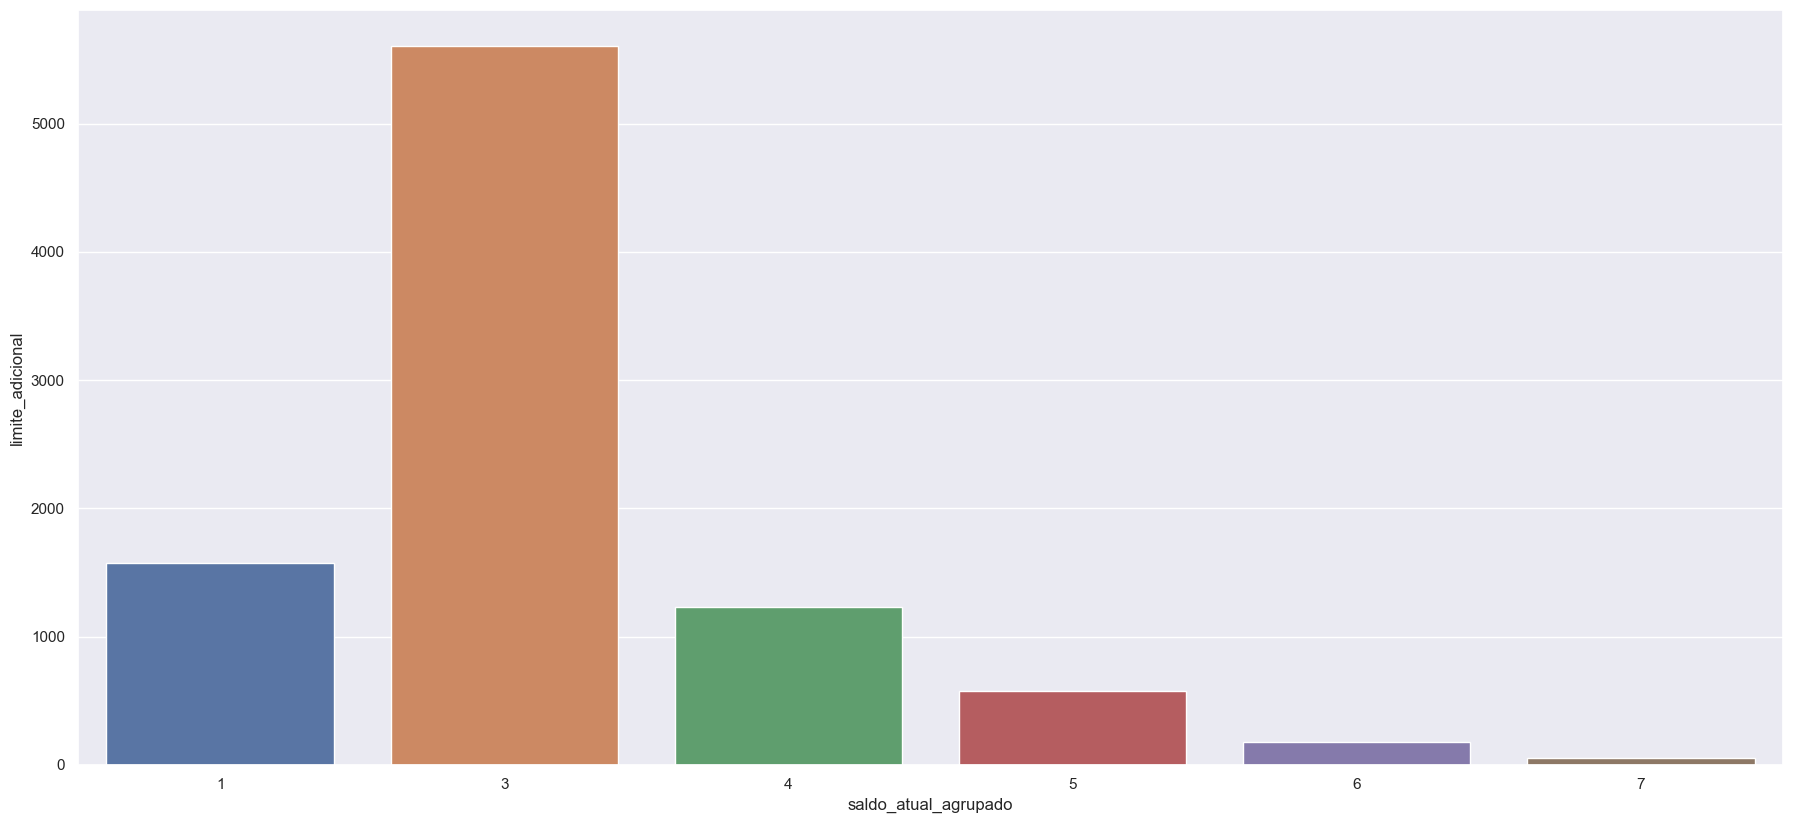

In [38]:
# Agrupando as idades blocos
df4['saldo_atual_agrupado'] = df4['saldo_atual'].apply( lambda x: 1 if x < 250 else
                                                               2 if ( 250 >= x < 500 ) else
                                                               3 if ( 500 >= x < 750 ) else
                                                               4 if ( 750 >= x < 1000 ) else
                                                               5 if ( 1000 >= x < 1250 ) else
                                                               6 if ( 1250 >= x < 1500 ) else
                                                               7)


# Plotando o número de negações por grupo
aux1 = df4[['saldo_atual_agrupado','limite_adicional']].groupby( 'saldo_atual_agrupado' ).count().reset_index()
sns.barplot(x='saldo_atual_agrupado', y='limite_adicional', data=aux1);

# 5 Preparação dos dados

In [776]:
df5 = df3.drop(columns=['idade', 'renda_anual', 'valor_em_investimentos', 'dias_atraso_dt_venc', 'divida_atual']).copy()

In [490]:
df5.columns

Index(['id_cliente', 'saldo_atual', 'taxa_utilizacao_credito',
       'num_emprestimos', 'num_contas_bancarias', 'num_cartoes_credito',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp', 'limite_adicional',
       'idade_binned', 'renda_anual_binned', 'investimentos_binned',
       'atraso_venc_binned', 'divida_atual_binned', 'taxa_divida',
       'renda_mensal', 'taxa_aplicacao'],
      dtype='object')

In [777]:
X = df5.drop(columns=['id_cliente', 'limite_adicional'])
y = df5['limite_adicional']

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
print(f'X train shape: {x_train.shape}')
print(f'X test shape: {x_test.shape}')
print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (7376, 15)
X test shape: (1845, 15)
y train shape: (7376,)
y test shape: (1845,)


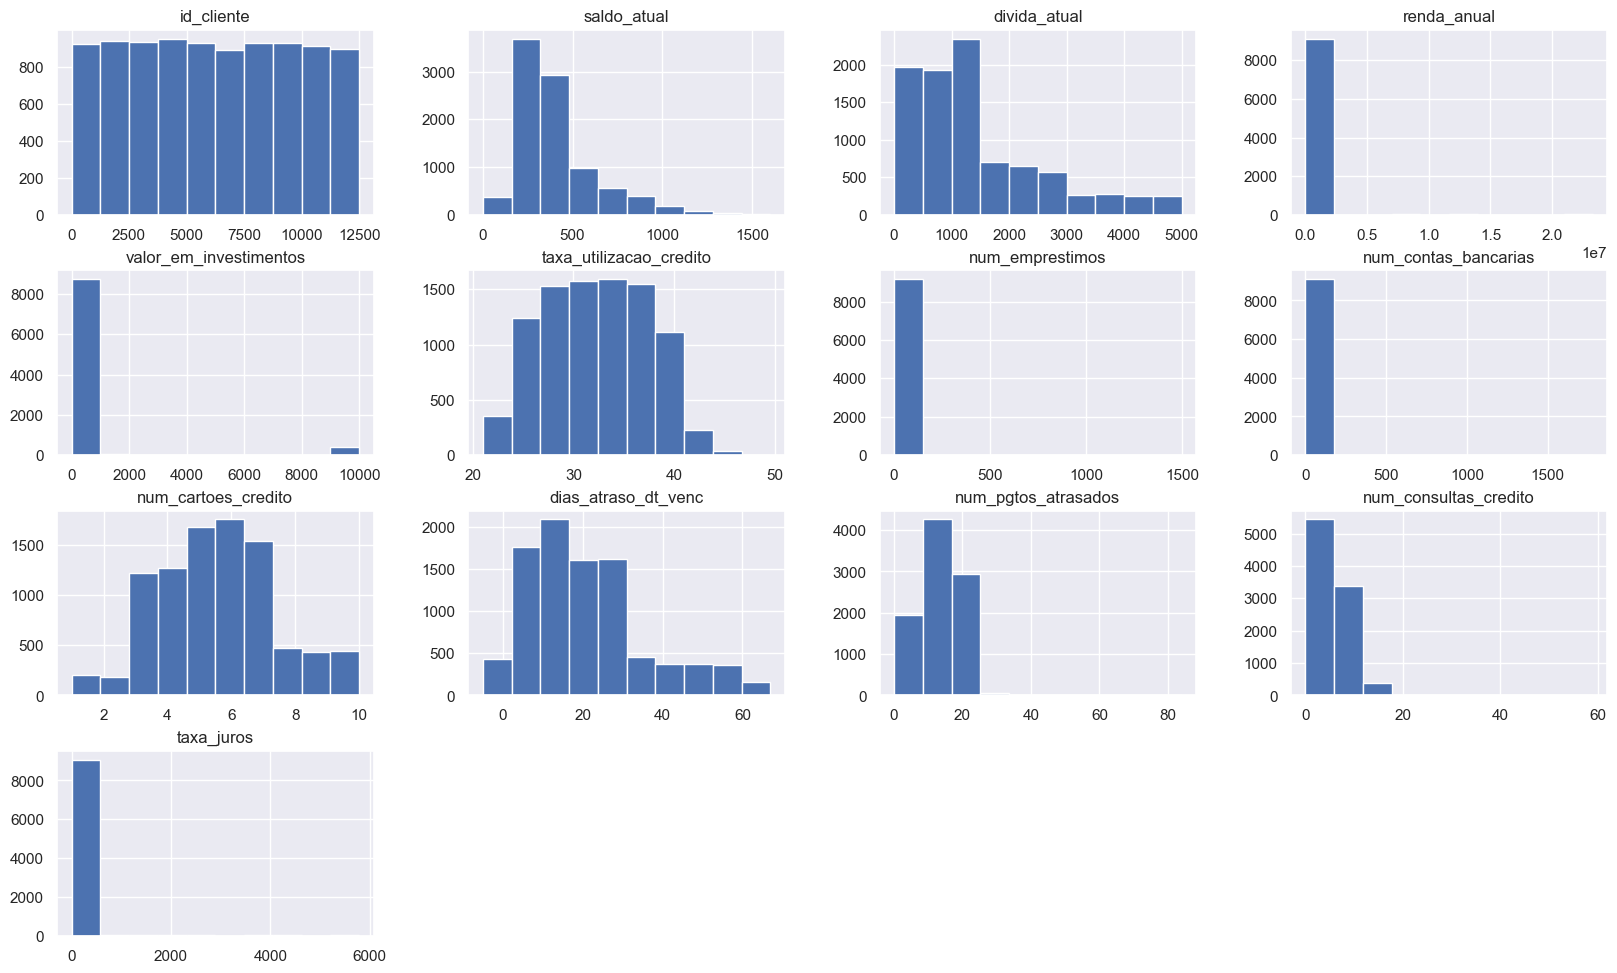

In [55]:
df5.hist(figsize=(20, 12));

#saldo atual, dias atraso dt venc = log

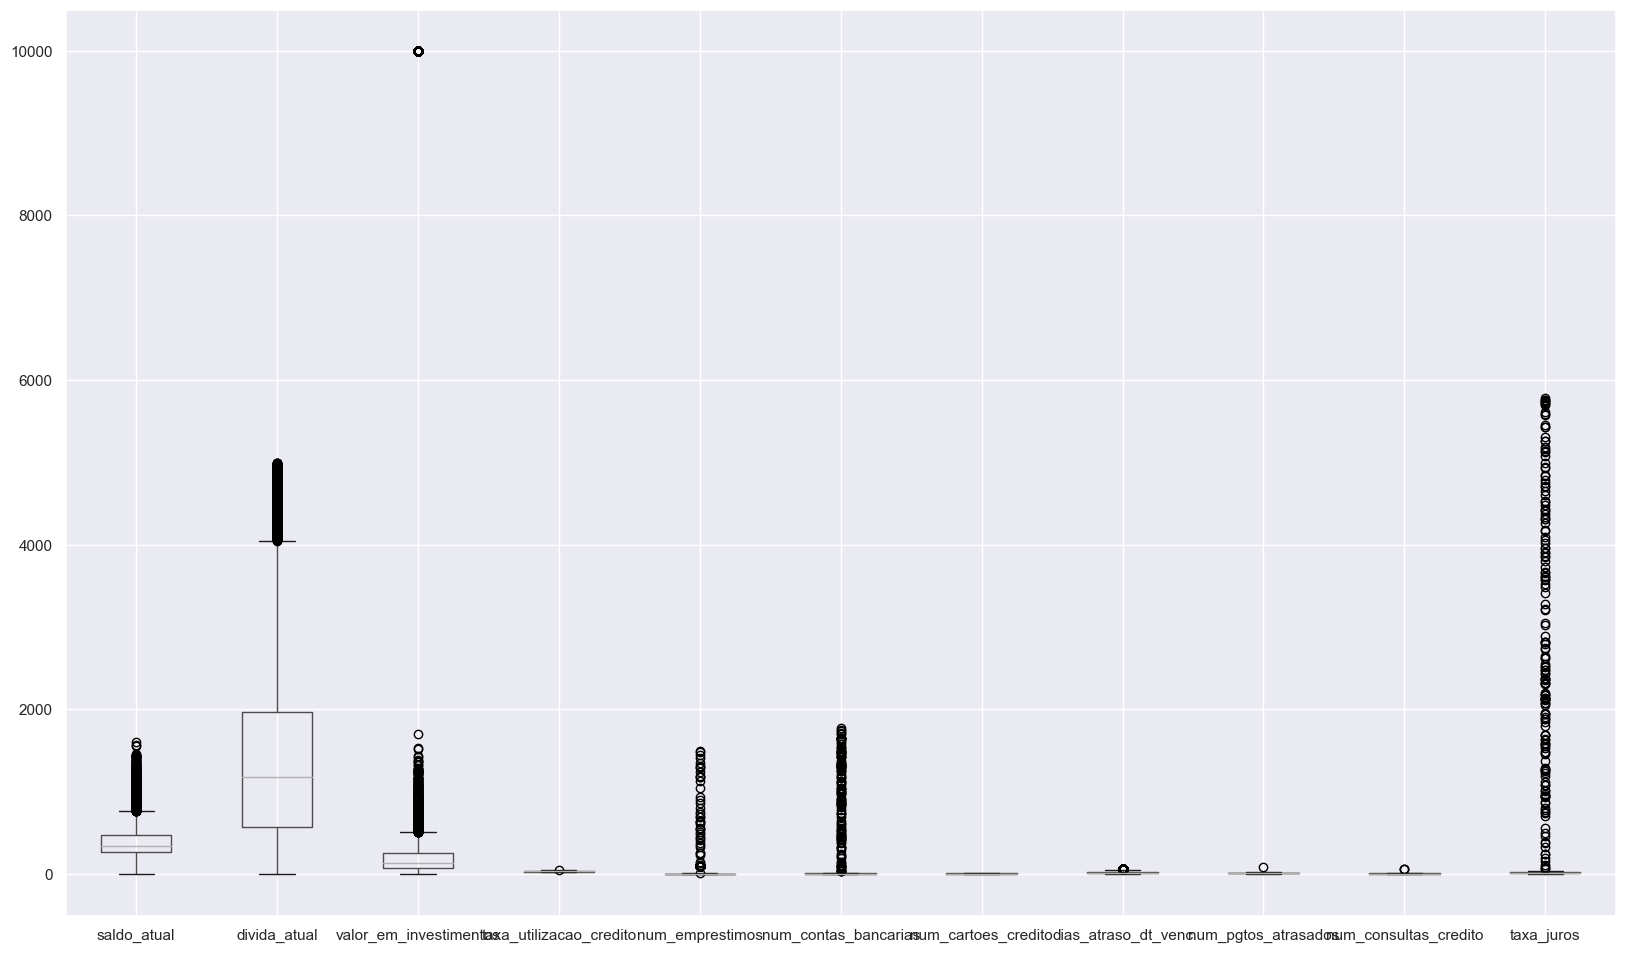

In [56]:
df5.drop(columns=['id_cliente', 'renda_anual']).boxplot(figsize=(20, 12));

## 5.1 Rescaling

In [45]:
x_train.columns

Index(['idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp'],
      dtype='object')

In [46]:
ss = pp.StandardScaler()
rs = pp.MinMaxScaler()

rs.fit(x_train[['idade']])

x_train['idade'] = rs.transform(x_train[['idade']])
df_val['idade'] = rs.transform(df_val[['idade']])

ss.fit(x_train[['saldo_atual']])

x_train['saldo_atual'] = ss.transform(x_train[['saldo_atual']])
df_val['saldo_atual'] = ss.transform(df_val[['saldo_atual']])


rs.fit(x_train[['divida_atual']])

x_train['divida_atual'] = rs.transform(x_train[['divida_atual']])
df_val['divida_atual'] = rs.transform(df_val[['divida_atual']])


rs.fit(x_train[['renda_anual']])

x_train['renda_anual'] = rs.transform(x_train[['renda_anual']])
df_val['renda_anual'] = rs.transform(df_val[['renda_anual']])


rs.fit(x_train[['valor_em_investimentos']])

x_train['valor_em_investimentos'] = rs.transform(x_train[['valor_em_investimentos']])
df_val['valor_em_investimentos'] = rs.transform(df_val[['valor_em_investimentos']])


rs.fit(x_train[['taxa_utilizacao_credito']])

x_train['taxa_utilizacao_credito'] = rs.transform(x_train[['taxa_utilizacao_credito']])
df_val['taxa_utilizacao_credito'] = rs.transform(df_val[['taxa_utilizacao_credito']])


rs.fit(x_train[['num_emprestimos']])

x_train['num_emprestimos'] = rs.transform(x_train[['num_emprestimos']])
df_val['num_emprestimos'] = rs.transform(df_val[['num_emprestimos']])


rs.fit(x_train[['num_contas_bancarias']])

x_train['num_contas_bancarias'] = rs.transform(x_train[['num_contas_bancarias']])
df_val['num_contas_bancarias'] = rs.transform(df_val[['num_contas_bancarias']])


rs.fit(x_train[['num_cartoes_credito']])

x_train['num_cartoes_credito'] = rs.transform(x_train[['num_cartoes_credito']])
df_val['num_cartoes_credito'] = rs.transform(df_val[['num_cartoes_credito']])


ss.fit(x_train[['dias_atraso_dt_venc']])

x_train['dias_atraso_dt_venc'] = ss.transform(x_train[['dias_atraso_dt_venc']])
df_val['dias_atraso_dt_venc'] = ss.transform(df_val[['dias_atraso_dt_venc']])


rs.fit(x_train[['num_pgtos_atrasados']])

x_train['num_pgtos_atrasados'] = rs.transform(x_train[['num_pgtos_atrasados']])
df_val['num_pgtos_atrasados'] = rs.transform(df_val[['num_pgtos_atrasados']])


rs.fit(x_train[['num_consultas_credito']])

x_train['num_consultas_credito'] = rs.transform(x_train[['num_consultas_credito']])
df_val['num_consultas_credito'] = rs.transform(df_val[['num_consultas_credito']])


rs.fit(x_train[['taxa_juros']])

x_train['taxa_juros'] = rs.transform(x_train[['taxa_juros']])
df_val['taxa_juros'] = rs.transform(df_val[['taxa_juros']])

NameError: name 'df_val' is not defined

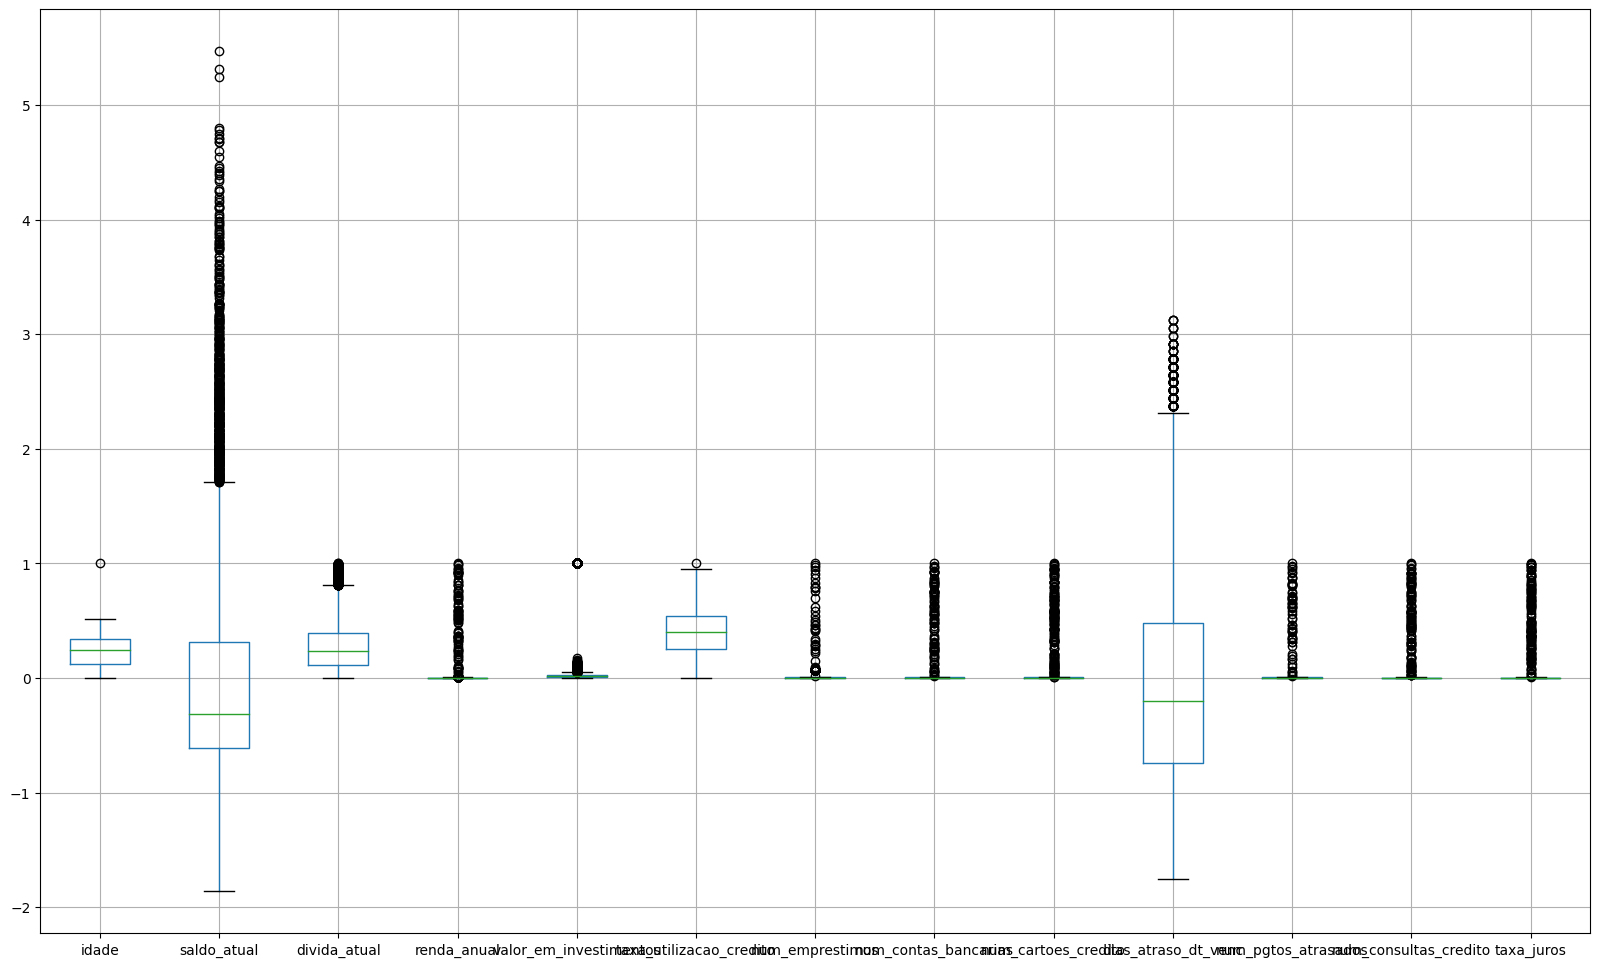

In [ ]:
x_train.boxplot(figsize=(20, 12));

## 5.2 Transformação

In [791]:
# label Encoder

le = pp.LabelEncoder()

# Variavel preditora
le.fit(y_train)
pickle.dump(le, open('work/le_y.pkl', 'wb'))

y_train = le.transform(y_train)
y_test = le.transform(y_test)


# Investe exterior
le.fit(x_train['investe_exterior'])
pickle.dump(le, open('work/le_investe_exterior.pkl', 'wb'))

x_train['investe_exterior'] = le.transform(x_train['investe_exterior'])
x_test['investe_exterior'] = le.transform(x_test['investe_exterior'])


# Pessoa politica exposta
le.fit(x_train['pessoa_polit_exp'])
pickle.dump(le, open('work/pessoa_polit_exp.pkl', 'wb'))

x_train['pessoa_polit_exp'] = le.transform(x_train['pessoa_polit_exp'])
x_test['pessoa_polit_exp'] = le.transform(x_test['pessoa_polit_exp'])



# # Idade binned
# le.fit(x_train['idade_binned'])
# pickle.dump(le, open('work/idade_binned.pkl', 'wb'))

# x_train['idade_binned'] = le.transform(x_train['idade_binned'])
# x_test['idade_binned'] = le.transform(x_test['idade_binned'])


# One Hot Encoding
# x_train = pd.get_dummies(x_train, prefix=['investe_exterior'], columns=['investe_exterior'])
# x_test = pd.get_dummies(x_test, prefix=['investe_exterior'], columns=['investe_exterior'])

# x_train = pd.get_dummies(x_train, prefix=['pessoa_polit_exp'], columns=['pessoa_polit_exp'])
# x_test = pd.get_dummies(x_test, prefix=['pessoa_polit_exp'], columns=['pessoa_polit_exp'])


# Frequency
# fe_investe_exterior = x_train.groupby('investe_exterior').size()/len(x_train)
# x_train.loc[:, 'investe_exterior'] = x_train['investe_exterior'].map(fe_investe_exterior)
# x_test.loc[:, 'investe_exterior'] = x_test['investe_exterior'].map(fe_investe_exterior)

# fe_pessoa_polit_exp = x_train.groupby('pessoa_polit_exp').size()/len(x_train)
# x_train.loc[:, 'pessoa_polit_exp'] = x_train['pessoa_polit_exp'].map(fe_pessoa_polit_exp)
# x_test.loc[:, 'pessoa_polit_exp'] = x_test['pessoa_polit_exp'].map(fe_pessoa_polit_exp)


# Target

# x_train['limite_adicional'] = le.transform(x_train['limite_adicional'])
# te_investe_exterior = x_train.groupby('investe_exterior')['limite_adicional'].mean()
# x_train.loc[:, 'investe_exterior'] = x_train['investe_exterior'].map(te_investe_exterior)
# x_test.loc[:, 'investe_exterior'] = x_test['investe_exterior'].map(te_investe_exterior)

# te_investe_exterior = x_train.groupby('pessoa_polit_exp')['limite_adicional'].mean()
# x_train.loc[:, 'pessoa_polit_exp'] = x_train['pessoa_polit_exp'].map(te_investe_exterior)
# x_test.loc[:, 'pessoa_polit_exp'] = x_test['pessoa_polit_exp'].map(te_investe_exterior)


# x_train = x_train.drop(columns=['limite_adicional'])
# x_test = x_test.drop(columns=['limite_adicional'])

# 6 Feature Selection

- balanceamento 
- cross validation 
- substituir outliers por um intervalo do desvio padrão
- Fazer redução de dimensionalidade/arrumar features por árvore

In [677]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# data preparation
forest.fit(x_train, y_train)

# saving model
# pickle.dump(forest, open('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/models/extra_tree_selector.pkl', 'wb'))

# loading model selector
# file = open('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/models/extra_tree_selector.pkl','rb')
# forest = pickle.load(file)
# file.close()

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature ranking:
                   feature  importance
0      num_cartoes_credito       0.134
0       atraso_venc_binned       0.116
0      num_pgtos_atrasados       0.103
0    num_consultas_credito       0.075
0               taxa_juros       0.061
0     num_contas_bancarias       0.056
0              taxa_divida       0.055
0              saldo_atual       0.051
0  taxa_utilizacao_credito       0.048
0             renda_mensal       0.048
0            taxa_deposito       0.048
0             idade_binned       0.045
0          num_emprestimos       0.042
0      divida_atual_binned       0.036
0     investimentos_binned       0.033
0       renda_anual_binned       0.023
0         investe_exterior       0.016
0         pessoa_polit_exp       0.010


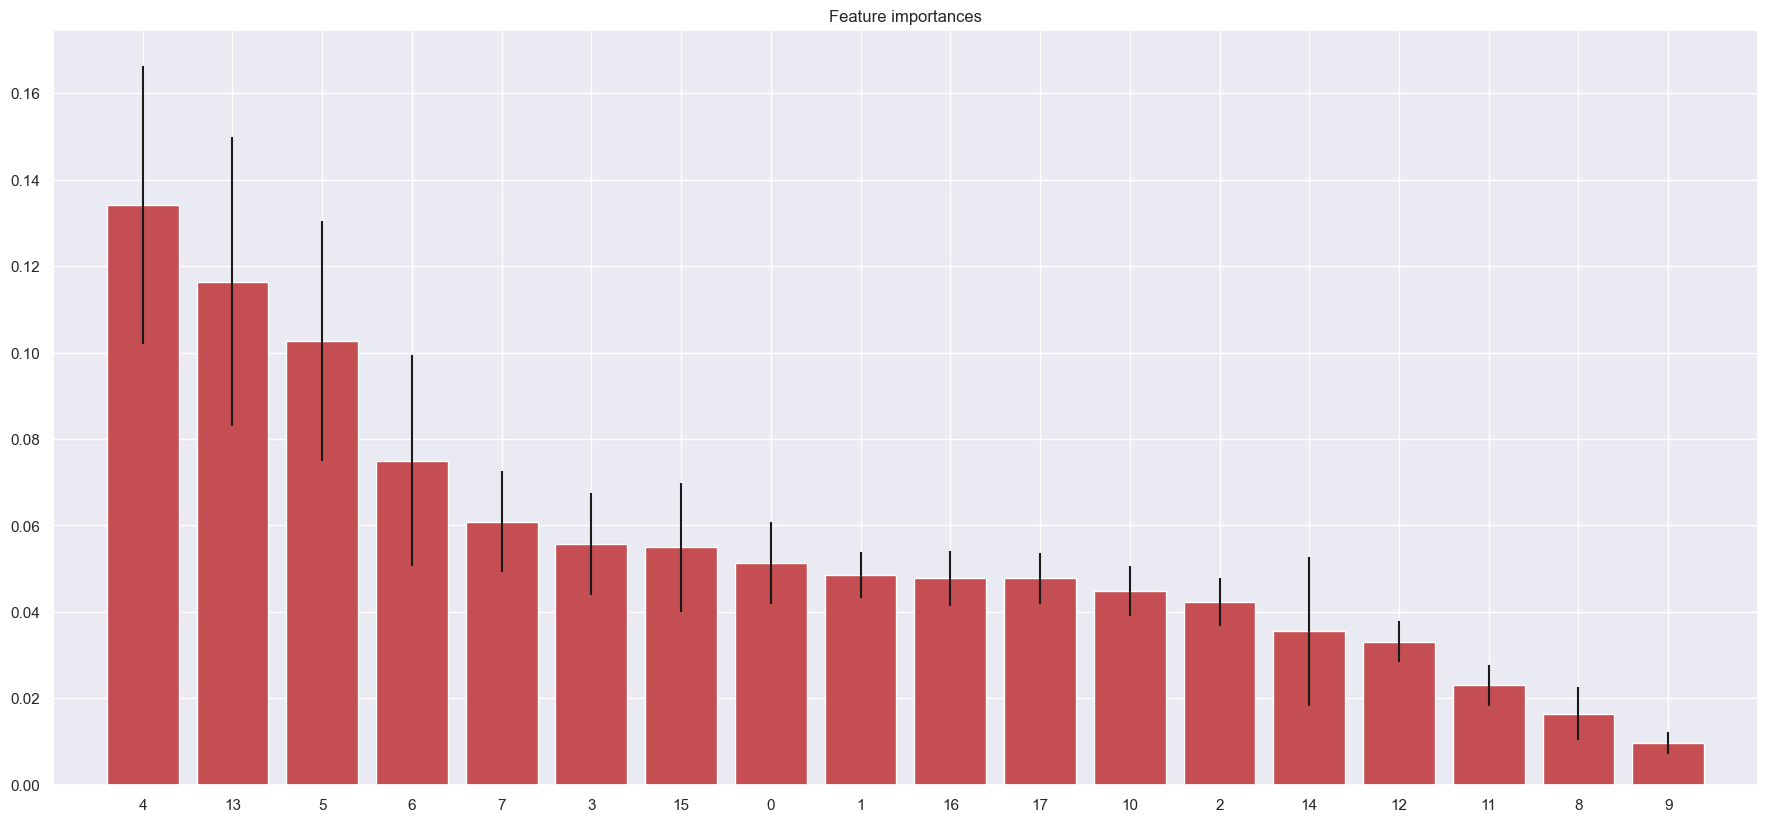

In [678]:
#Collect features from model selector
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Organize and print ranking per features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train, forest.feature_importances_):
   aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
   df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

#plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show();

# 7.0 ML Modeling

## 7.1 Extra Trees

In [757]:
et_model = en.ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample').fit(x_train, y_train)

y_hat = et_model.predict(x_test)

f1_score(y_test, y_hat)

0.9333333333333332

## 7.2 Random Forest

In [756]:
rf_model = en.RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced').fit(x_train, y_train)

y_hat = rf_model.predict(x_test)

f1_score(y_test, y_hat)

0.9350730040385213

## 7.3 XGBoost

In [754]:
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample').fit(x_train, y_train)

y_hat = xgb_model.predict(x_test)

f1_score(y_test, y_hat)

f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
f:\SamuelOliveiraAlvesd\Anaconda3\envs\competitions\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:57:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:57:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9331240188383045

## 7.4 LightBGM

In [761]:
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

y_hat = lgbm_model.predict(x_test)

f1_score(y_test, y_hat)

0.9352608422375863

# 8 Hyper Parameter Fine Tunning

In [762]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver

In [795]:
from sklearn.model_selection import RepeatedStratifiedKFold

def runCrossValidation(model, x, y, n_splits, n_repeats=1):

        f1_score_list = []
        cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats )

        for train_index, prim_val_index in cv.split(x, y):      
                x_training, x_prim_val = x.iloc[train_index], x.iloc[prim_val_index]
                y_training, y_prim_val = y.iloc[train_index], y.iloc[prim_val_index]


                # fit and predict/predict_proba
                model.fit(x_training, y_training)
                yhat_prob = model.predict(x_prim_val)


                f1_metric = f1_score(y_prim_val, yhat_prob)

                f1_score_list.append(f1_metric)

        df_results = pd.DataFrame([[np.mean(f1_score_list),np.std(f1_score_list)]], 
                columns = ['mean', 'std'])
    
        df_results.index = ['f1_score']
    
        return(df_results)


In [779]:
X_cross = X.copy()
y_cross = y.copy()

X_cross['investe_exterior'] = le_investe_exterior.transform(X_cross['investe_exterior'])
X_cross['pessoa_polit_exp'] = le_pessoa_polit_exp.transform(X_cross['pessoa_polit_exp'])


y_cross = le_y.transform(y_cross)
y_cross = pd.Series(y_cross)

In [ ]:
# model definition
lgbm_model = LGBMClassifier(n_jobs=-1, random_state=42, subsample_freq=1, objective='binary')


# Search space for hyper parameters
search_space = [Integer( 100, 1500, name = 'n_estimators'), 
                Integer(1, 20, name = 'max_depth'), 
                Real(0.001, 0.1, 'log-uniform', name = 'learning_rate'),
                Integer(2, 128, name = 'num_leaves'),
                Integer(1, 100, name = 'min_child_samples'),
                Real(0.05, 1.0, name = 'subsample'),
                Real(0.15, 1.0, name = 'colsample_bytree')]



# applying cross-validation into tunning
@use_named_args(search_space)
def model_eval( **params ):
	
    lgbm_model.set_params(**params)
    print(lgbm_model)
    ft_result = runCrossValidation(lgbm_model, X_cross, y_cross, n_splits=10, n_repeats=1)
    return -ft_result['mean'][0]


# create checkpoints
checkpoint_callback = CheckpointSaver('work/lgbm_ft.pkl')

# return results and run bayesian optimize
result = gp_minimize( model_eval, search_space, n_calls = 650, 
                      n_initial_points = 10, verbose=True, n_jobs=-1, 
                      random_state= 42, callback=[checkpoint_callback])
result

In [ ]:
result.x

[567, 4, 0.020034427927560734, 9, 72, 0.9416250735649628, 0.15066195096486218]

In [ ]:
colsample_bytree=0.17078137774401306,
               learning_rate=0.021881516062712658, max_depth=3,
               min_child_samples=10, n_estimators=1443, num_leaves=16,
               objective='binary', random_state=42,
               subsample=0.9462819636602591, subsample_freq=1

# 9 Test data

In [726]:
df_val_raw = pd.read_csv('work/test.csv', low_memory=False)

In [727]:
df_val = df_val_raw.drop(columns=['id_cliente']).copy()

In [728]:
# Filtragem de linhas - Numero de cartoes
num_cartao_median = df_val['num_cartoes_credito'].median()
df_val['num_cartoes_credito'] = df_val['num_cartoes_credito'].apply(lambda x: num_cartao_median if x >=16 else x)

# Filtragem de linhas - Numero de pagamentos atrasados
num_pgto_median = df_val['num_pgtos_atrasados'].median()
df_val['num_pgtos_atrasados'] = df_val['num_pgtos_atrasados'].apply(lambda x: num_pgto_median if x >=85 else x)

# Filtragem de linhas - Numero de consultas de credito
num_consul_median = df_val['num_consultas_credito'].median()
df_val['num_consultas_credito'] = df_val['num_consultas_credito'].apply(lambda x: num_consul_median if x >=60 else x)

In [729]:
# Features
# Bins idade
bins = [10, 18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 8500]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
df_val['idade_binned'] = pd.cut(df_val['idade'], bins=bins, labels=labels)
df_val['idade_binned'] = df_val['idade_binned'].astype('int64')

# Bins renda anual - Bom
bins = [10000, 50000, 100000, 200000, 500000, 1000000, 24000000]
labels = [0, 1, 2, 3, 4, 5]
df_val['renda_anual_binned'] = pd.cut(df_val['renda_anual'], bins=bins, labels=labels)
df_val['renda_anual_binned'] = df_val['renda_anual_binned'].astype('int64')

# Investimentos
bins = [-0.1, 150, 300, 600, 800, 1000, 1250, 3000, 10000]
labels = [0, 1, 2, 3, 4, 5, 6, 7]
df_val['investimentos_binned'] = pd.cut(df_val['valor_em_investimentos'], bins=bins, labels=labels)
df_val['investimentos_binned'] = df_val['investimentos_binned'].astype('int64')

# dias atraso
bins = [-6, 2, 9, 16, 23, 30, 37, 70]
labels = [0, 1, 2, 3, 4, 5, 6]
df_val['atraso_venc_binned'] = pd.cut(df_val['dias_atraso_dt_venc'], bins=bins, labels=labels)
df_val['atraso_venc_binned'] = df_val['atraso_venc_binned'].astype('int64')

bins = [0, 1000, 2000, 3000, 4000, 5000]
labels = [0, 1, 2, 3, 4]
df_val['divida_atual_binned'] = pd.cut(df_val['divida_atual'], bins=bins, labels=labels)
df_val['divida_atual_binned'] = df_val['divida_atual_binned'].astype('int64')

#razão entre dívida atual/saldo atual ou renda_anual(renda mensal)
df_val['taxa_divida'] = df_val.apply(lambda x: x['divida_atual'] / (x['renda_anual']/12), axis=1)

df_val['renda_mensal'] = df_val.apply(lambda x: x['renda_anual'] /12, axis=1)

# fazer renda mensal e depois razão entre saldo atual/renda mensal
df_val['taxa_deposito'] = df_val.apply(lambda x: x['saldo_atual'] / x['renda_mensal'], axis=1)

In [730]:
df_val = df_val.drop(columns=['idade', 'renda_anual', 'valor_em_investimentos', 'dias_atraso_dt_venc', 'divida_atual'])

In [732]:
#le_investe_exterior = pickle.load(open('work/le_investe_exterior.pkl', 'rb'))
#le_pessoa_polit_exp = pickle.load(open('work/pessoa_polit_exp.pkl', 'rb'))

df_val['investe_exterior'] = le_investe_exterior.transform(df_val['investe_exterior'])
df_val['pessoa_polit_exp'] = le_pessoa_polit_exp.transform(df_val['pessoa_polit_exp'])

In [738]:
y_val = lgbm_model.predict(df_val)
df_val_raw['limite_adicional'] = y_val

In [739]:
df_val_raw['limite_adicional'] = le_y.inverse_transform(df_val_raw['limite_adicional'].values)

In [740]:
df_val_raw = df_val_raw.drop(columns=['idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp'])

df_val_raw.head()

,id_cliente,limite_adicional
0,2,Negar
1,5,Negar
2,6,Negar
3,8,Negar
4,10,Negar


In [741]:
df_val_raw.to_csv('work/submit12.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=104b8296-2d41-4515-8c24-57b523e008af' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>